In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")
from dataloader import DataLoader
import seaborn as sns
import pycountry

import matplotlib.pyplot as plt

In [3]:
loader = DataLoader(hs_code=282520)

_initialize_data took 28.6266 seconds


In [4]:
polar_df = loader.get_data()
df = polar_df.to_pandas()

years = sorted(df['t'].unique())
top_n = 20

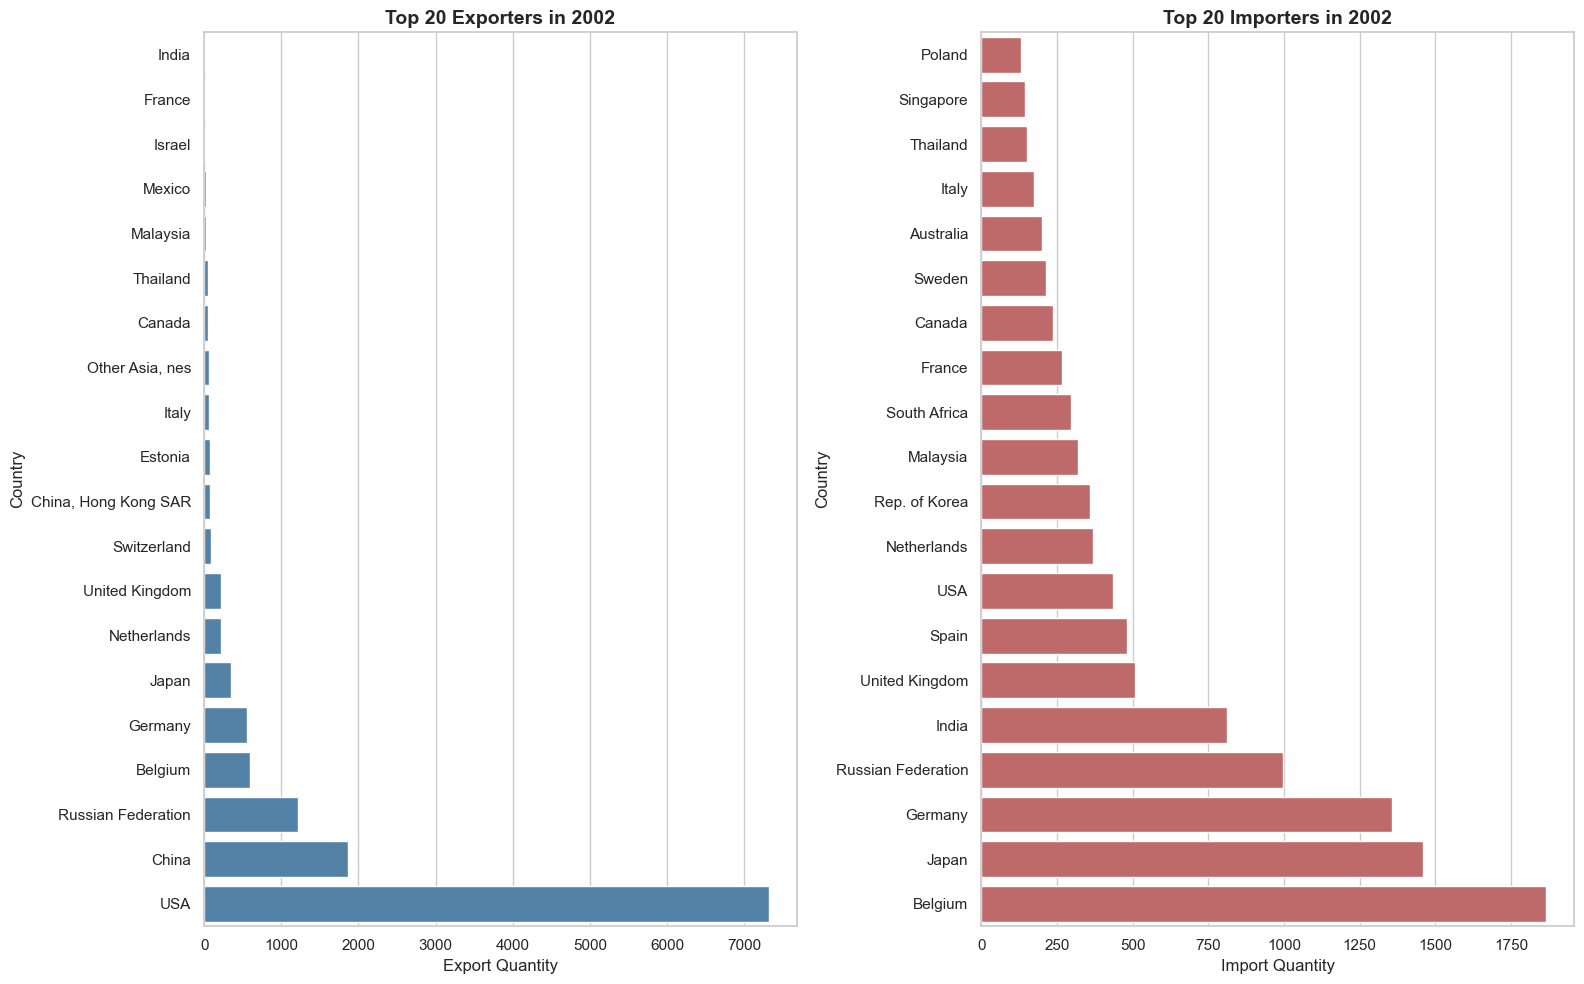

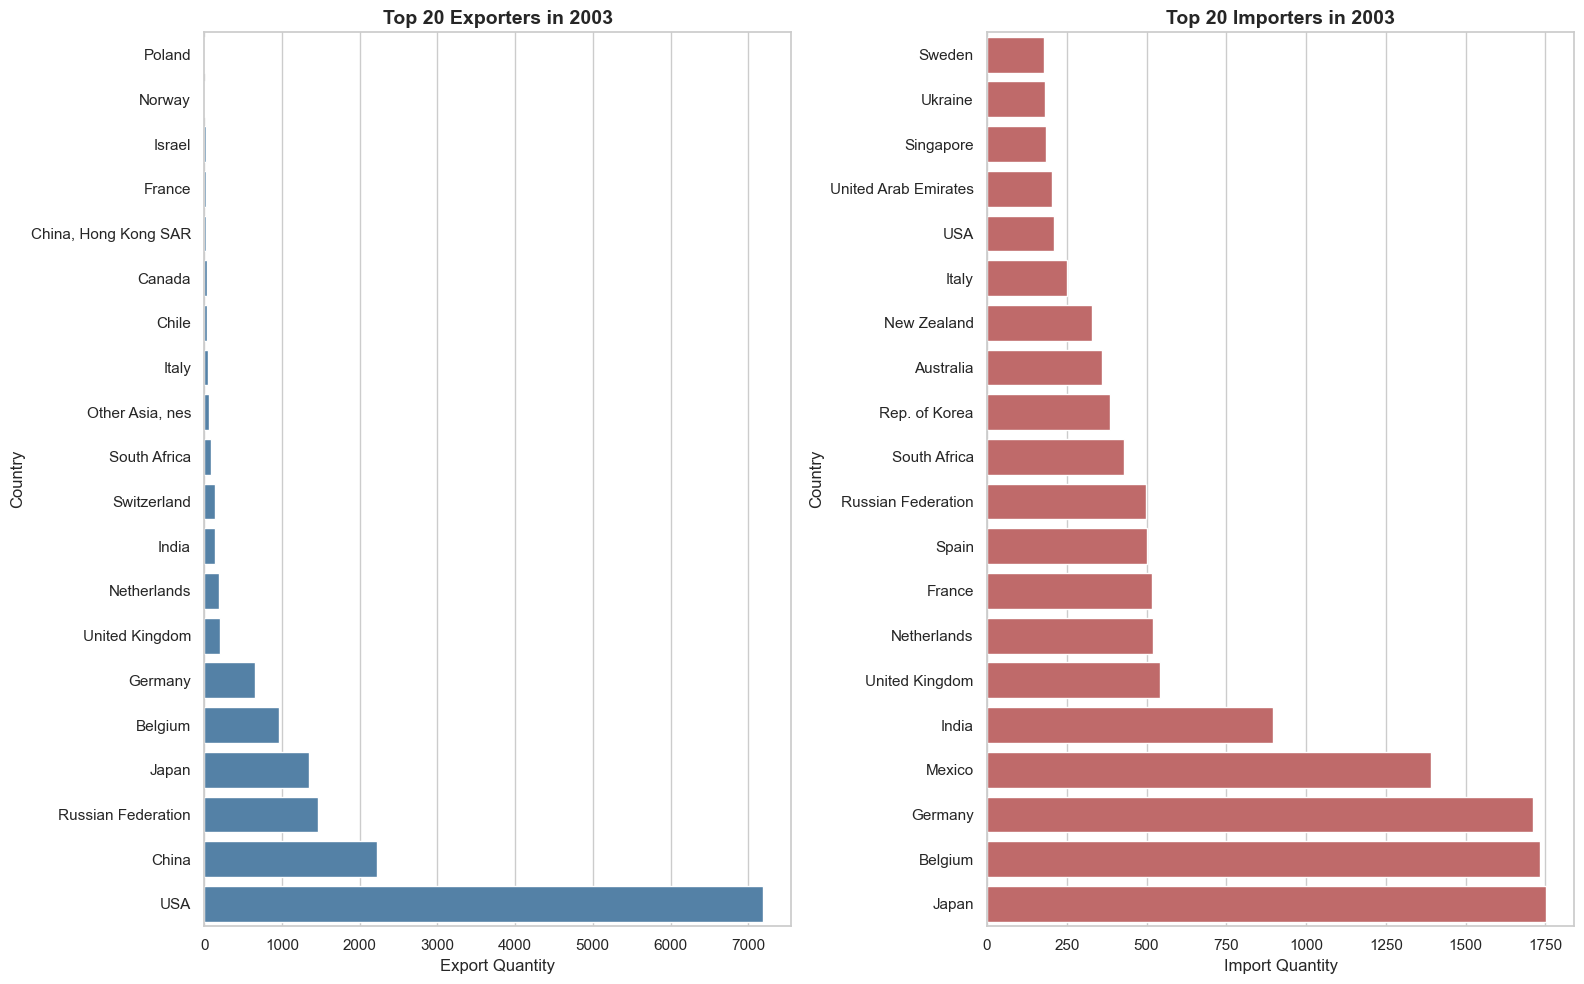

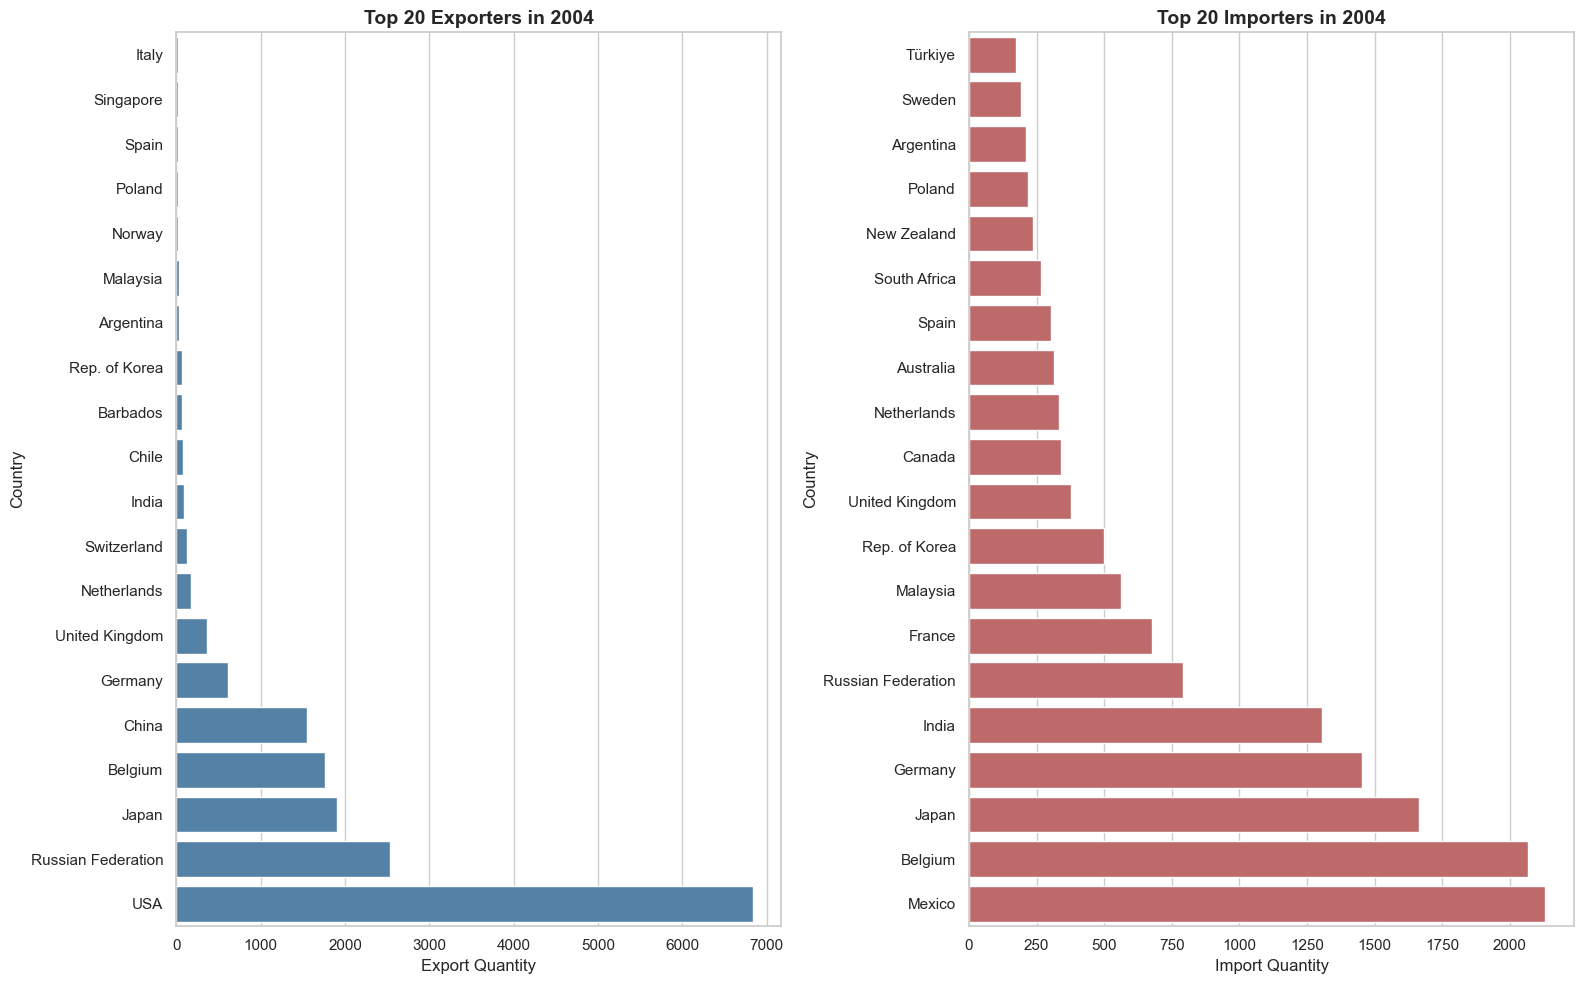

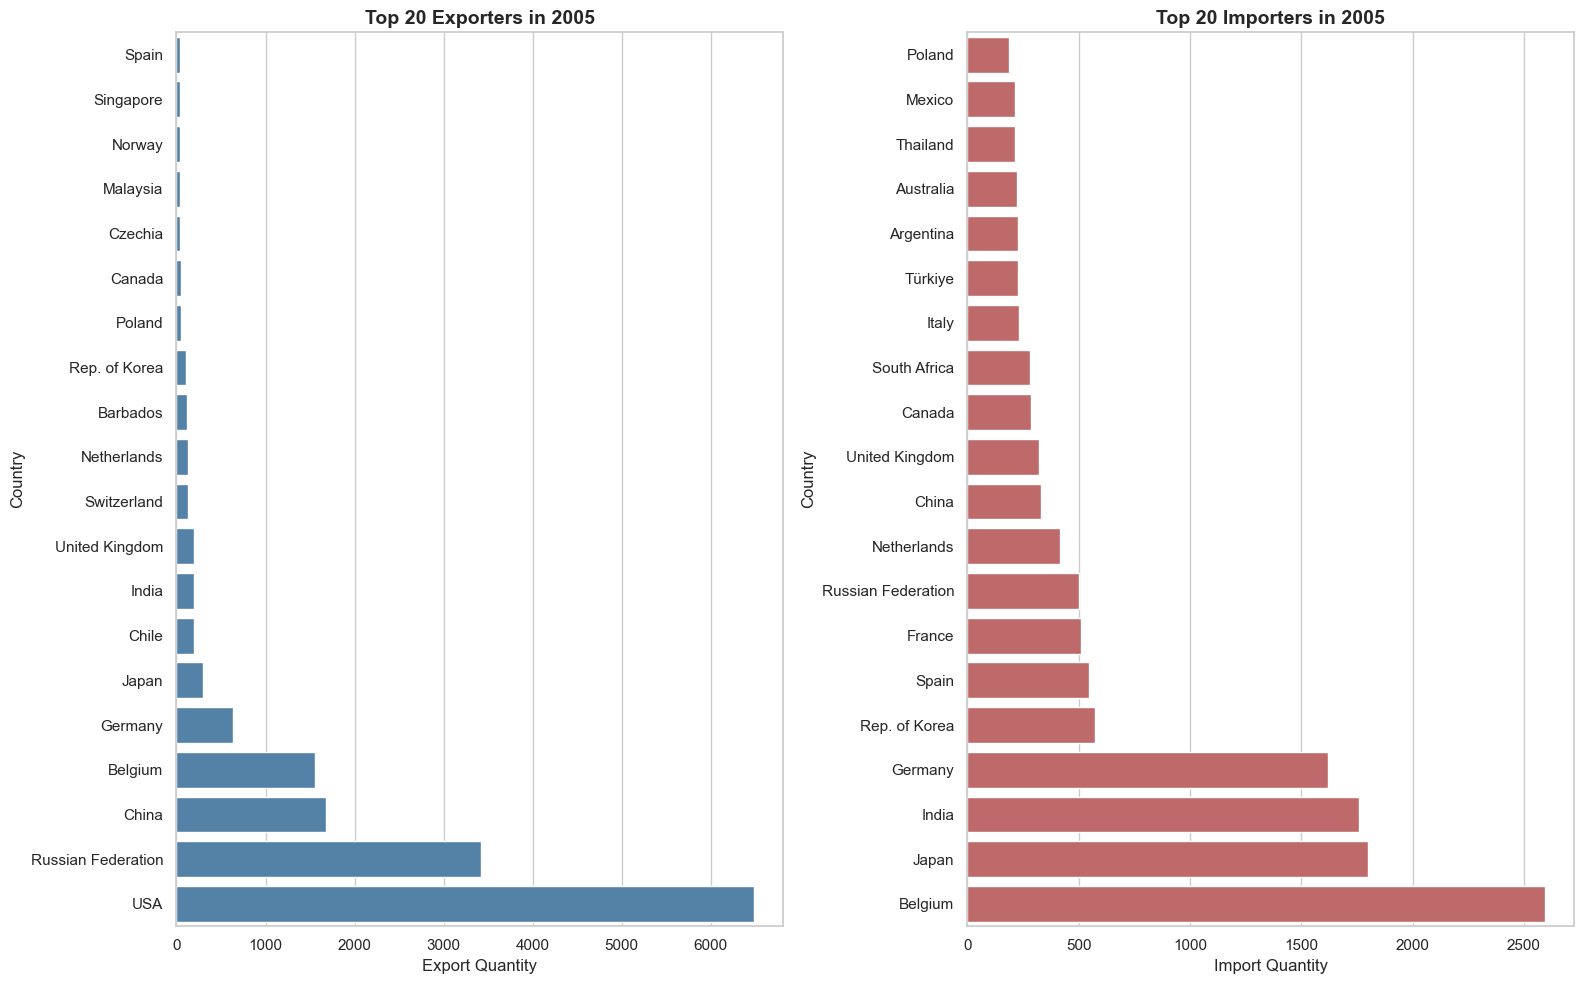

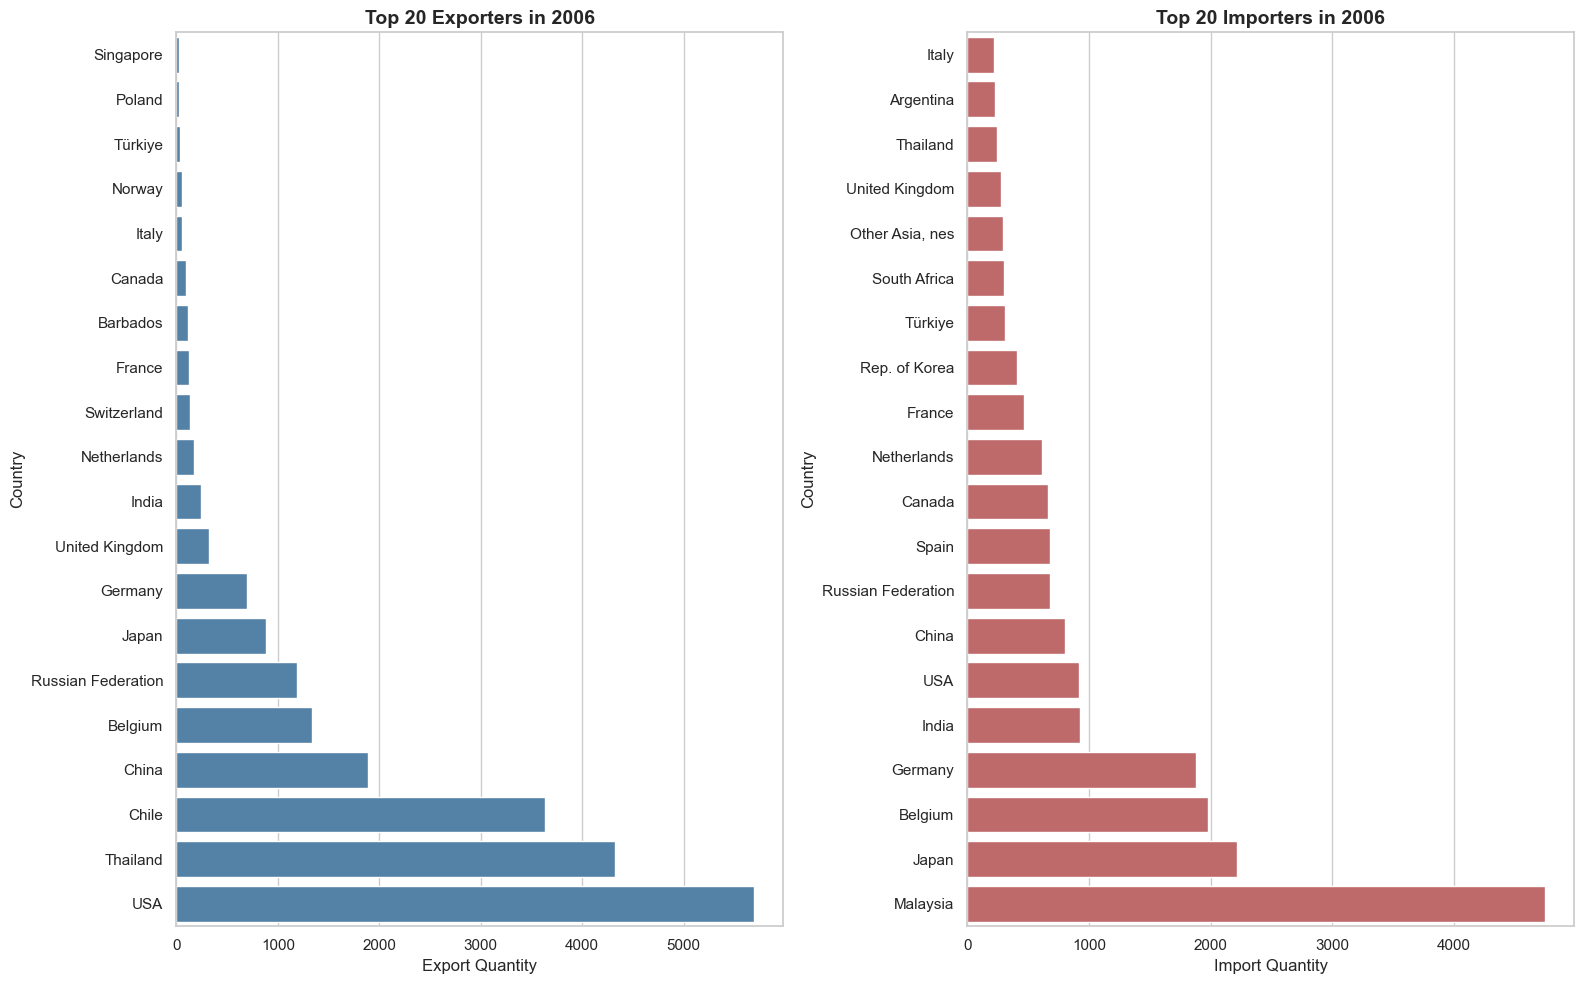

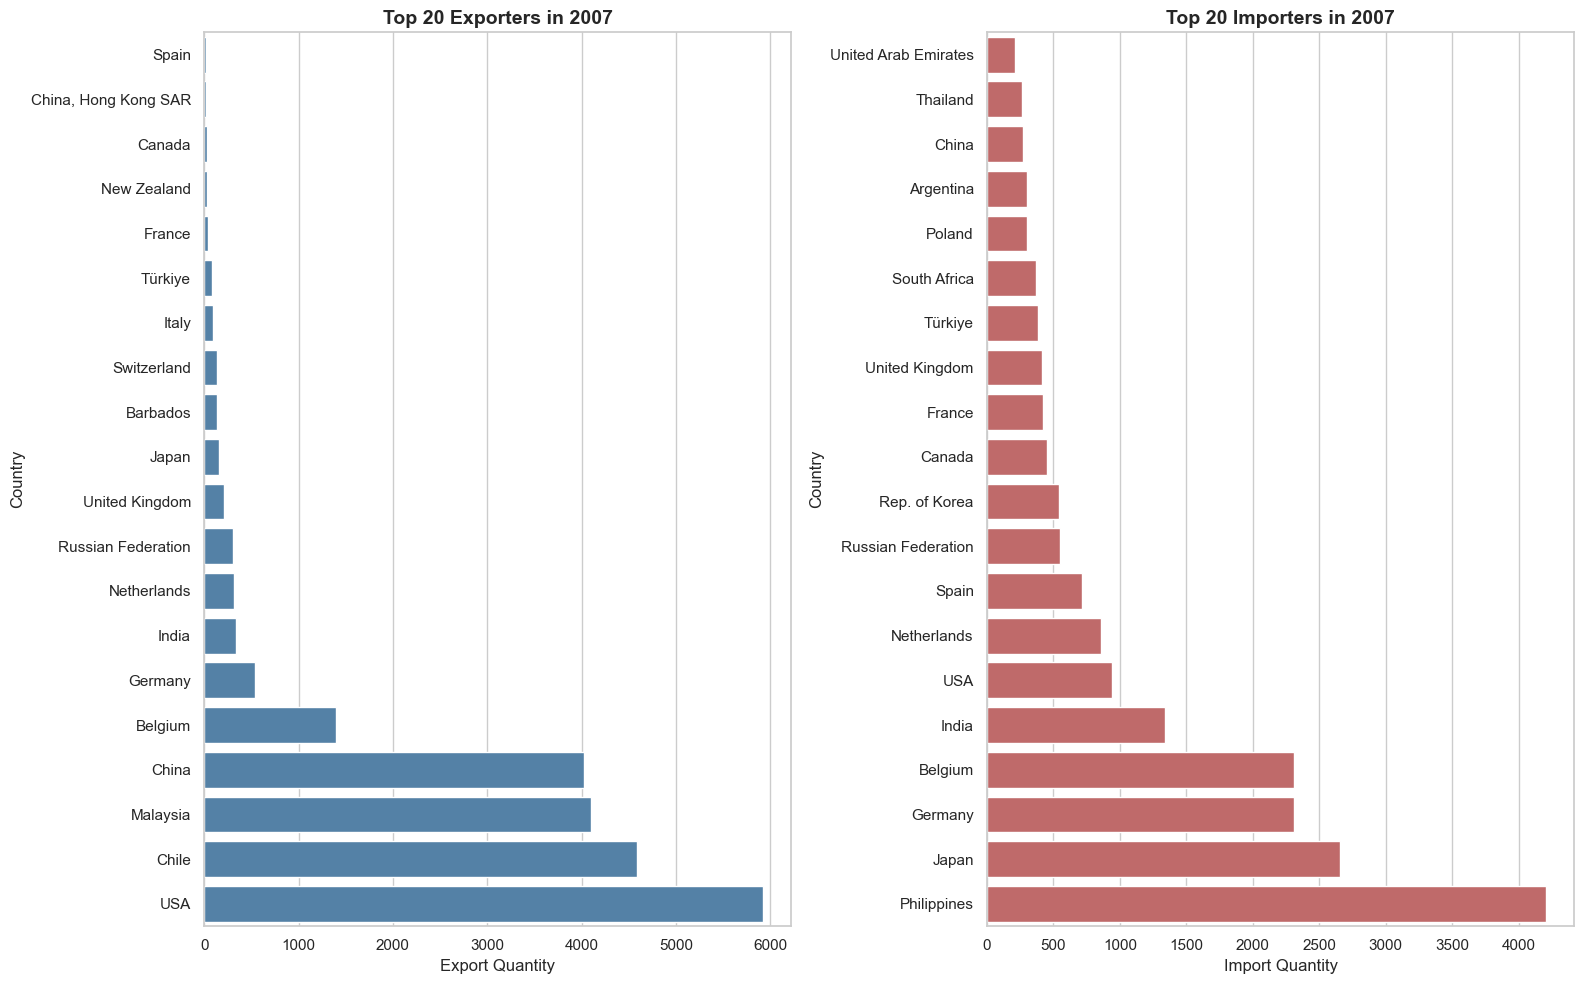

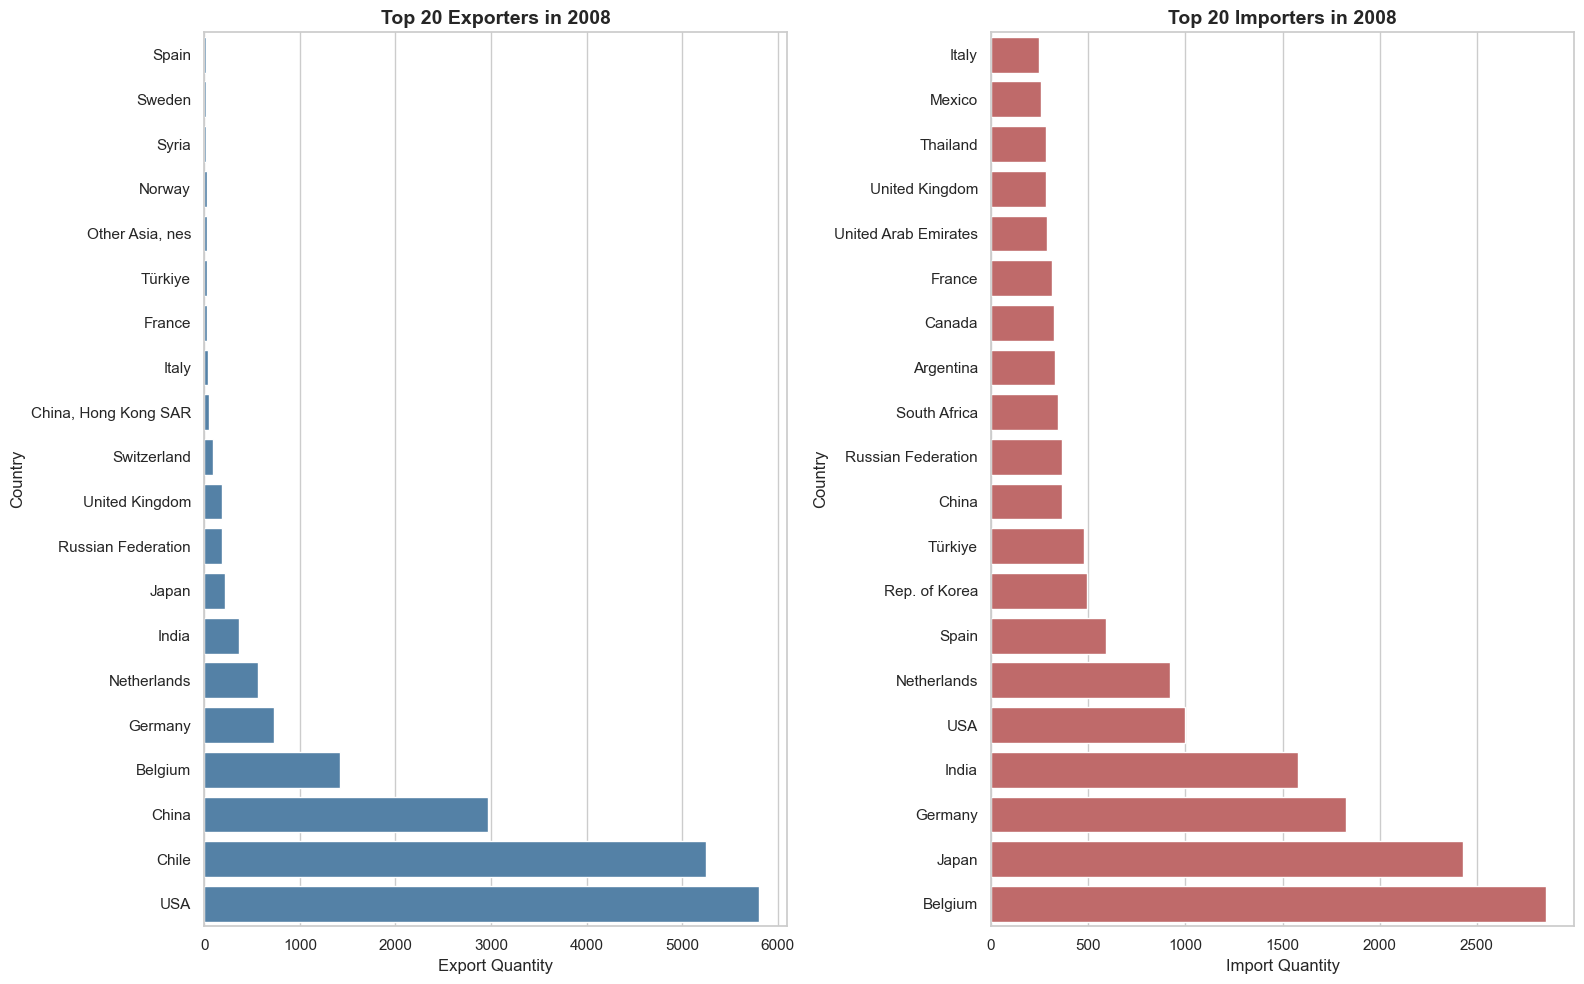

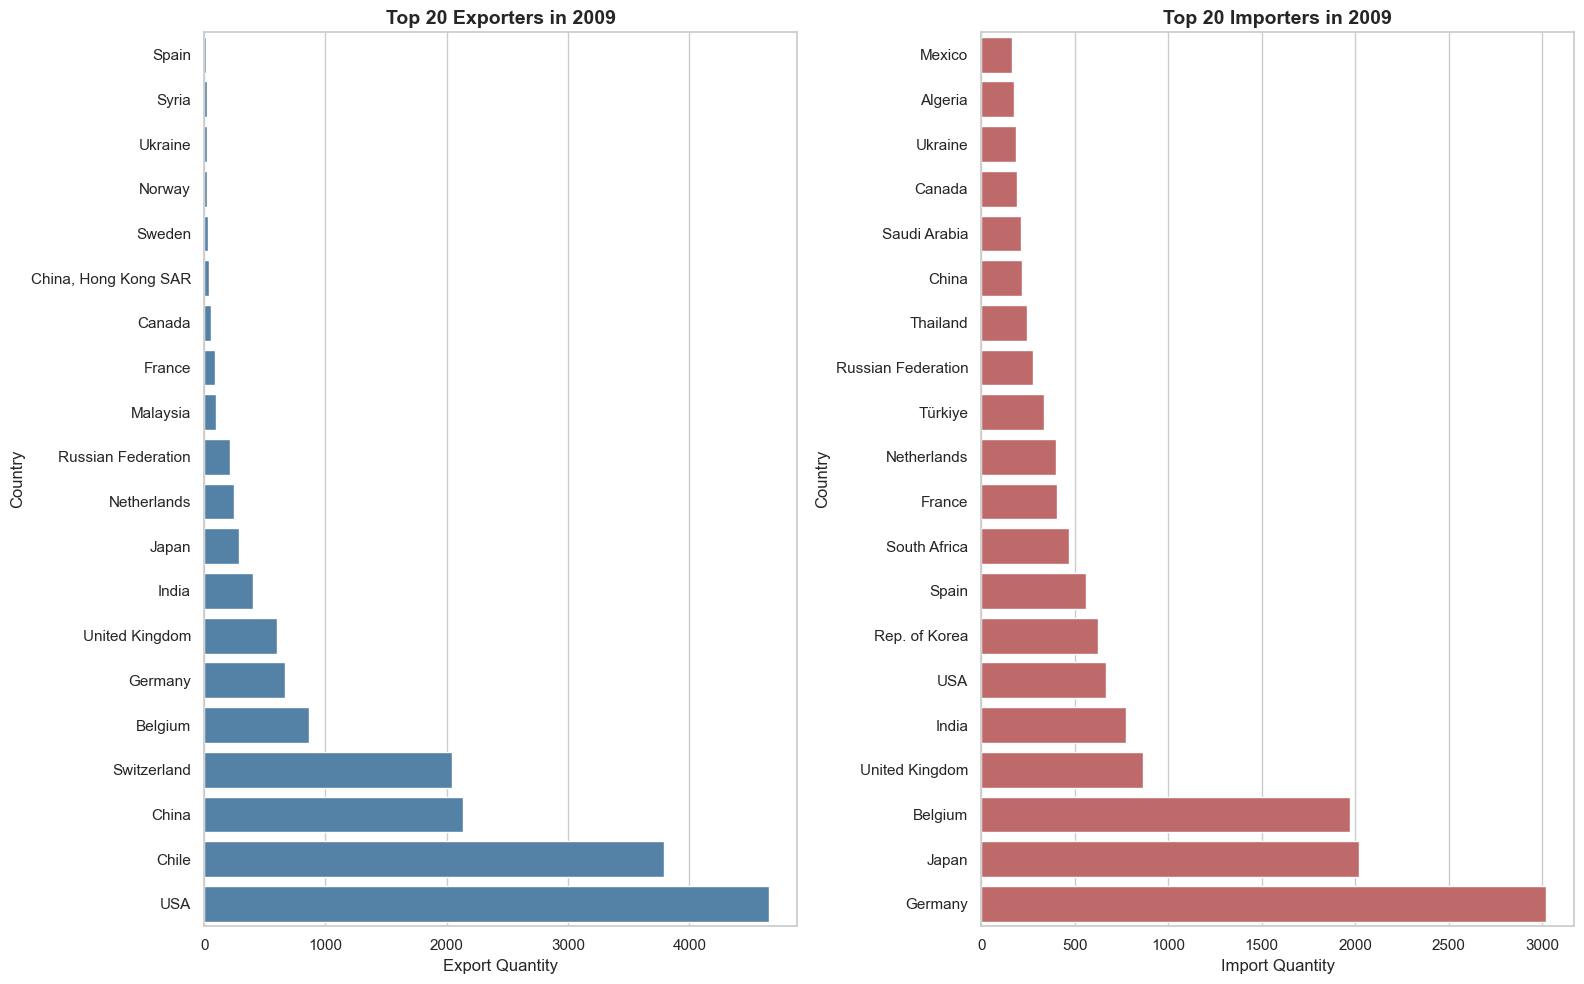

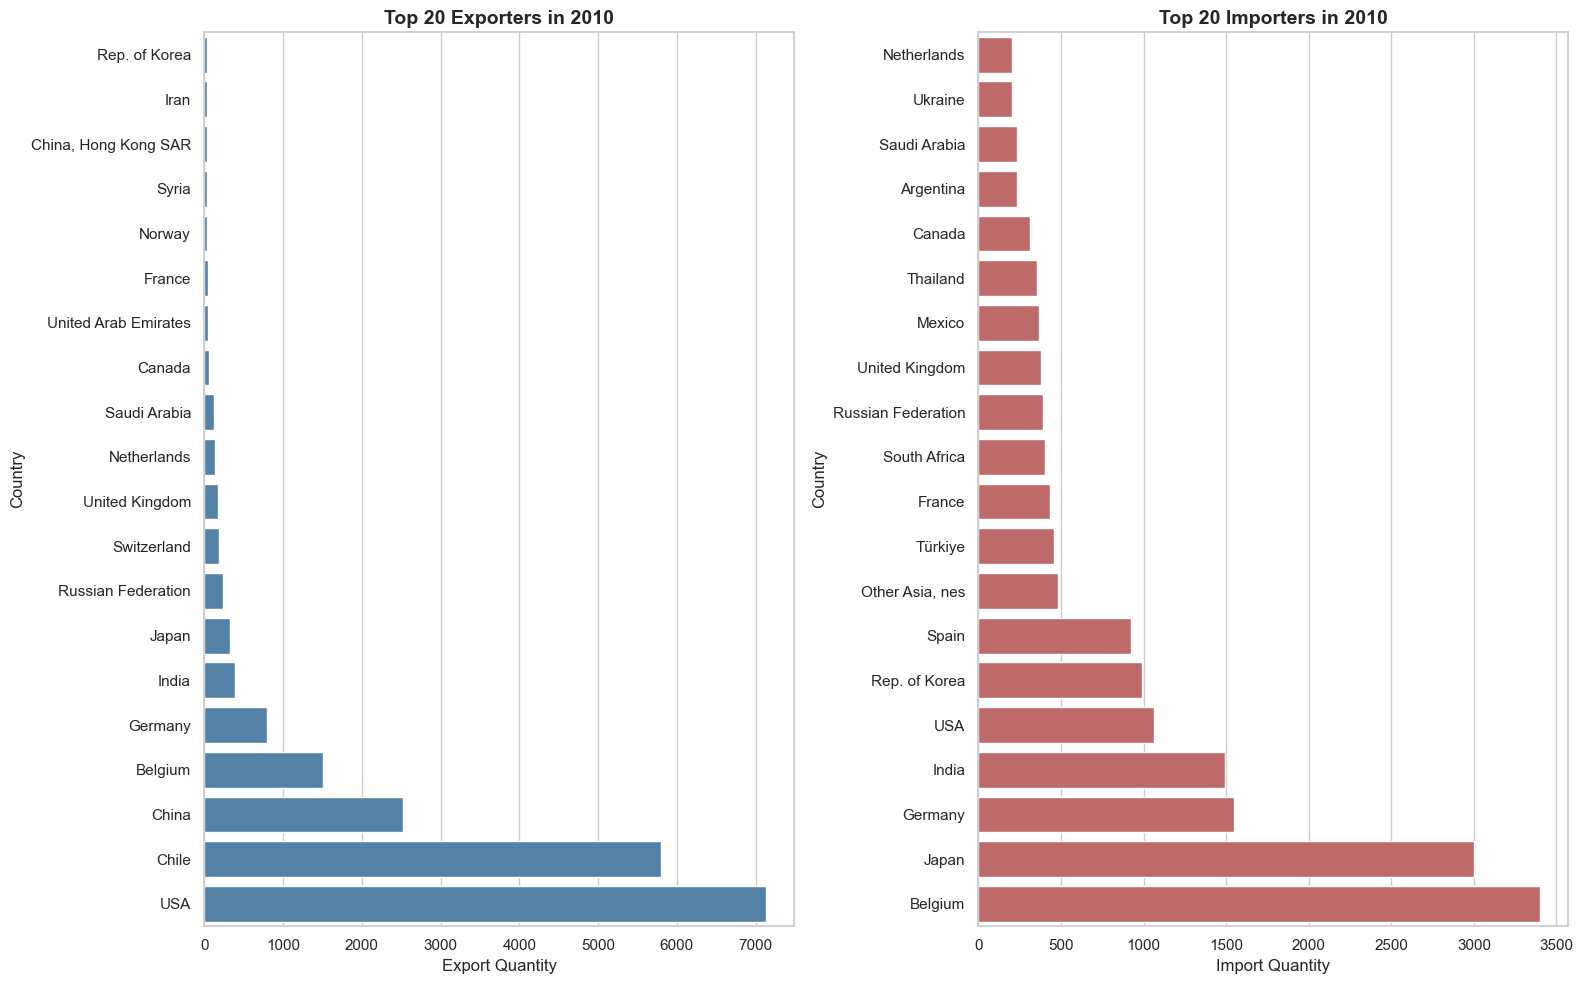

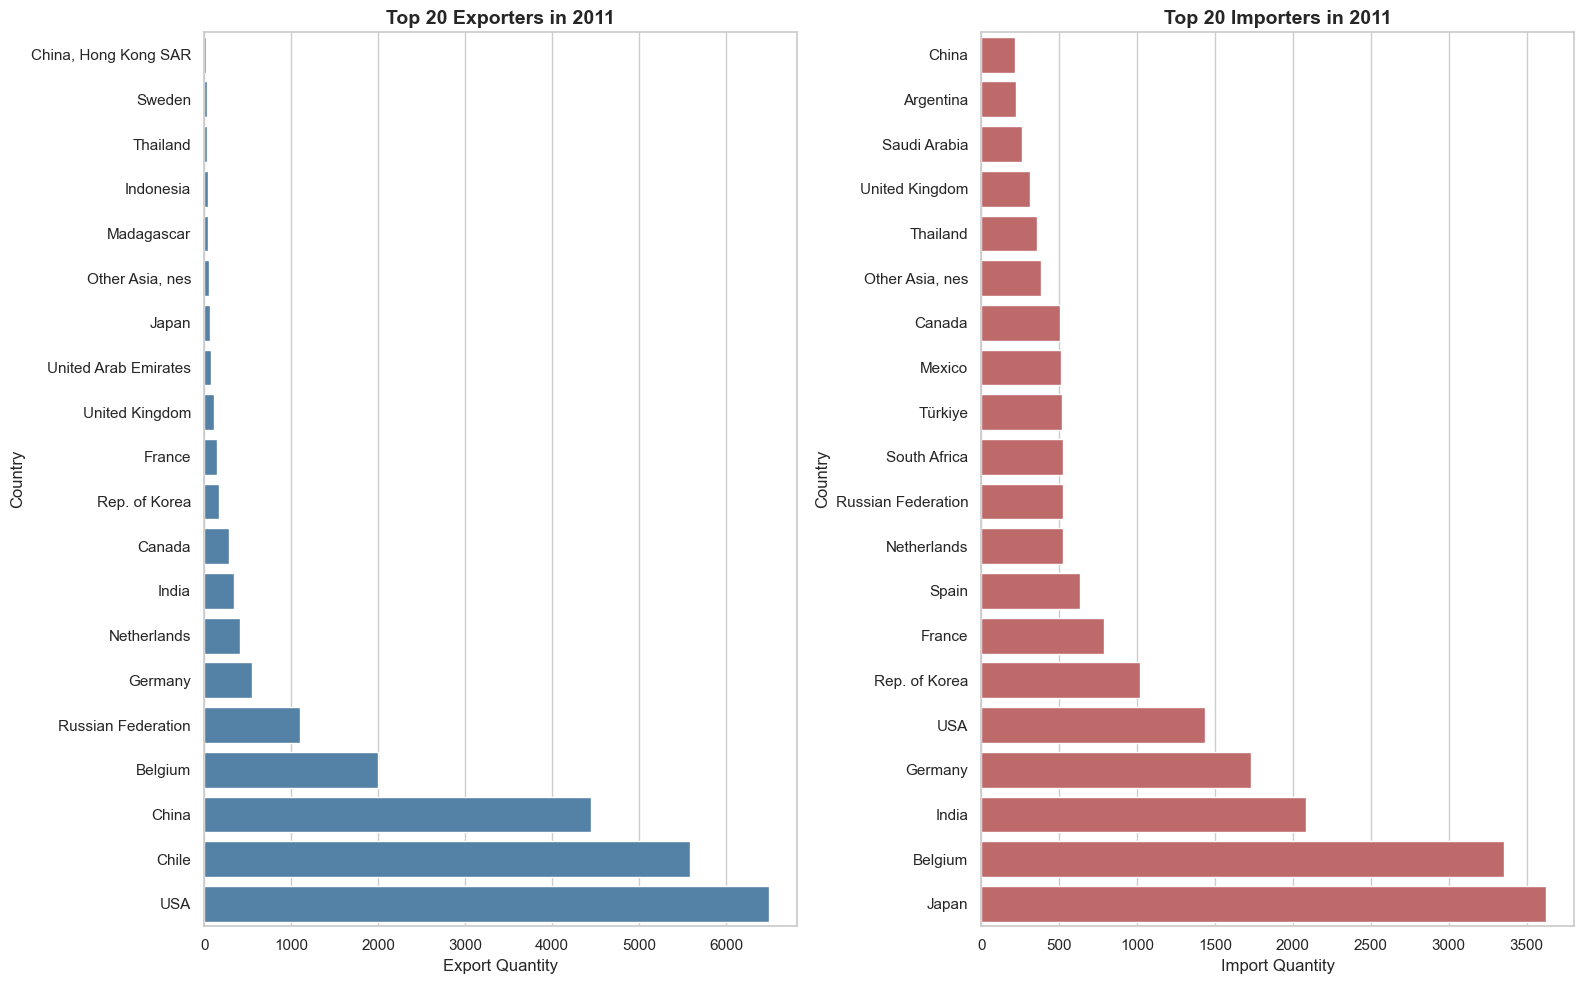

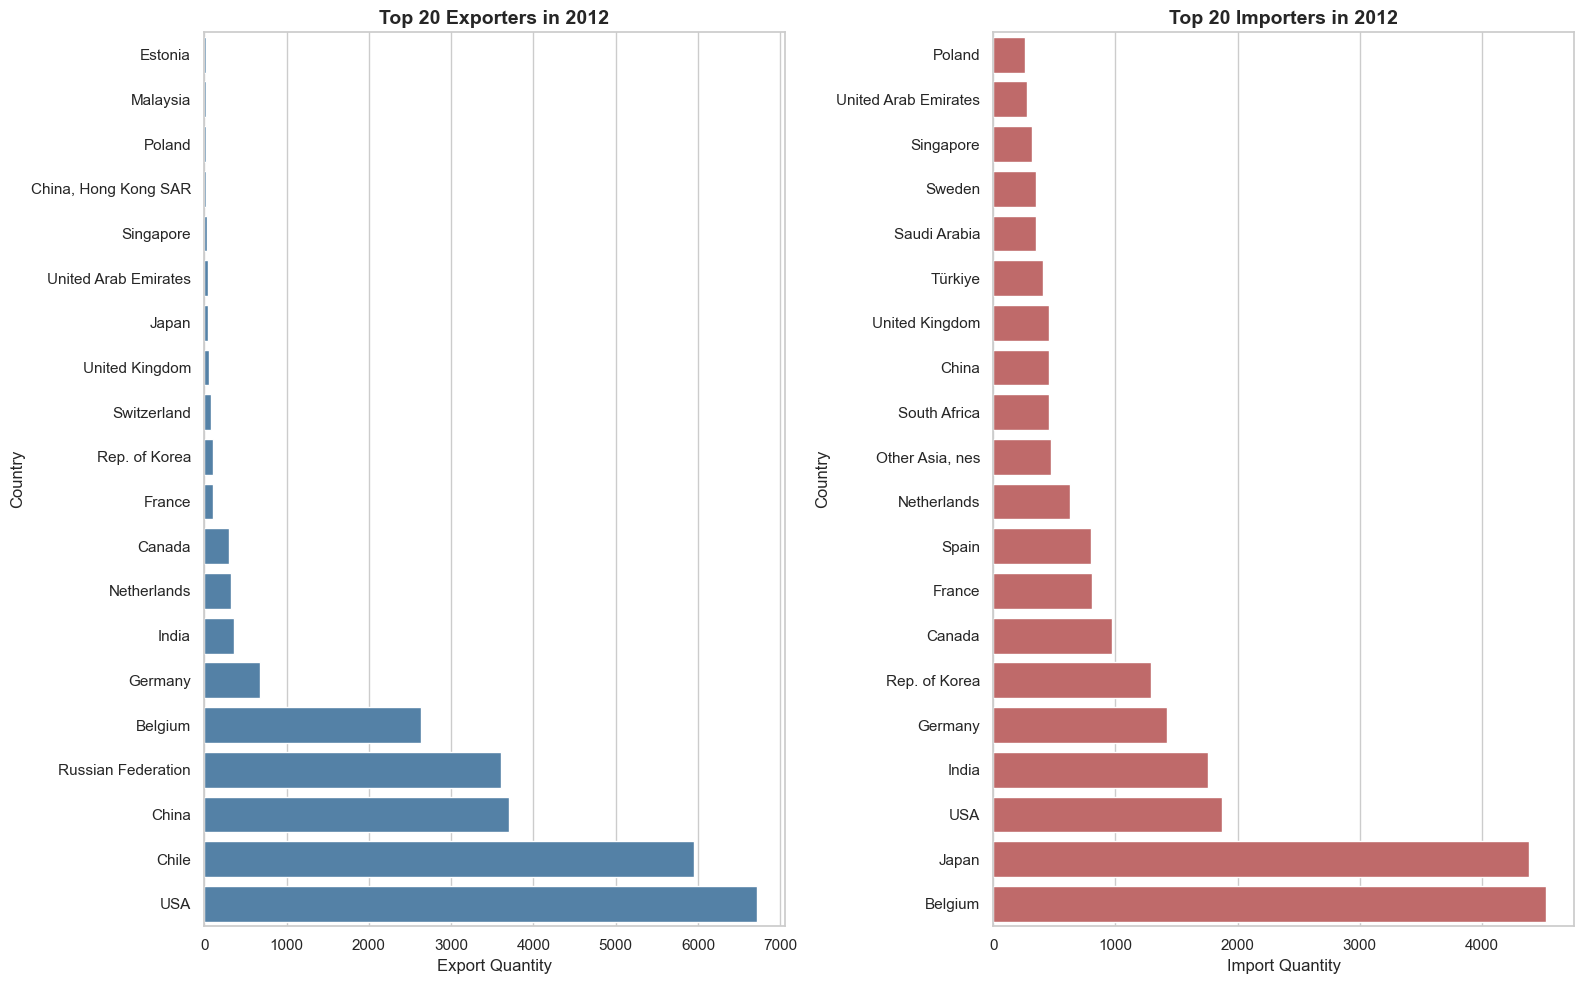

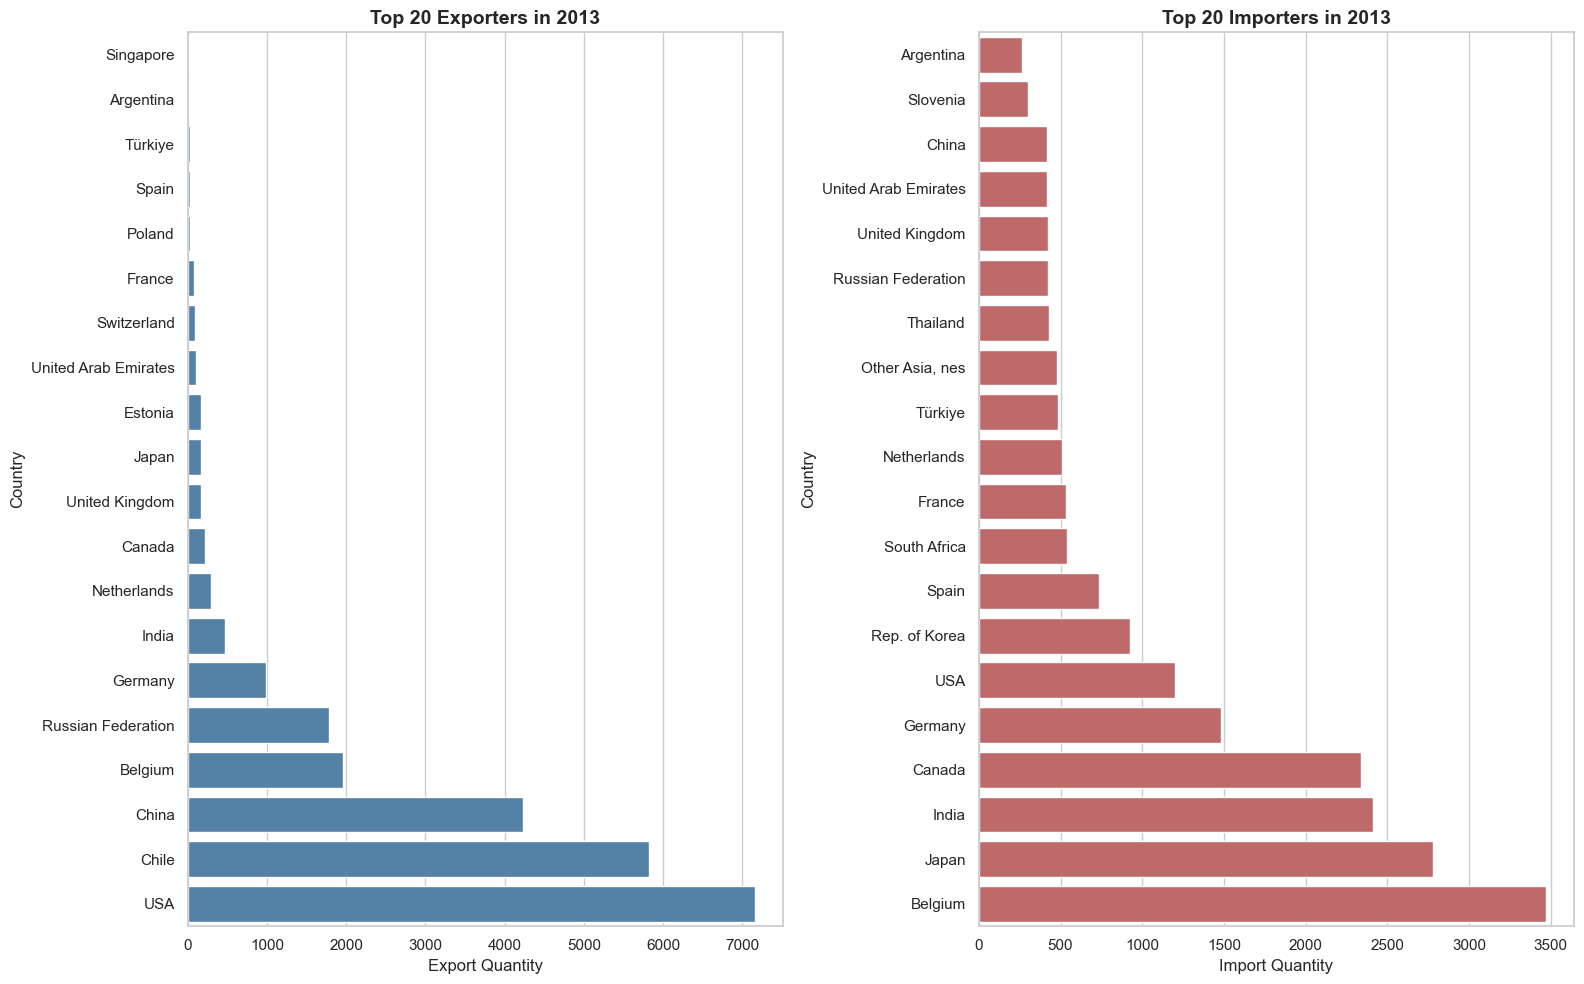

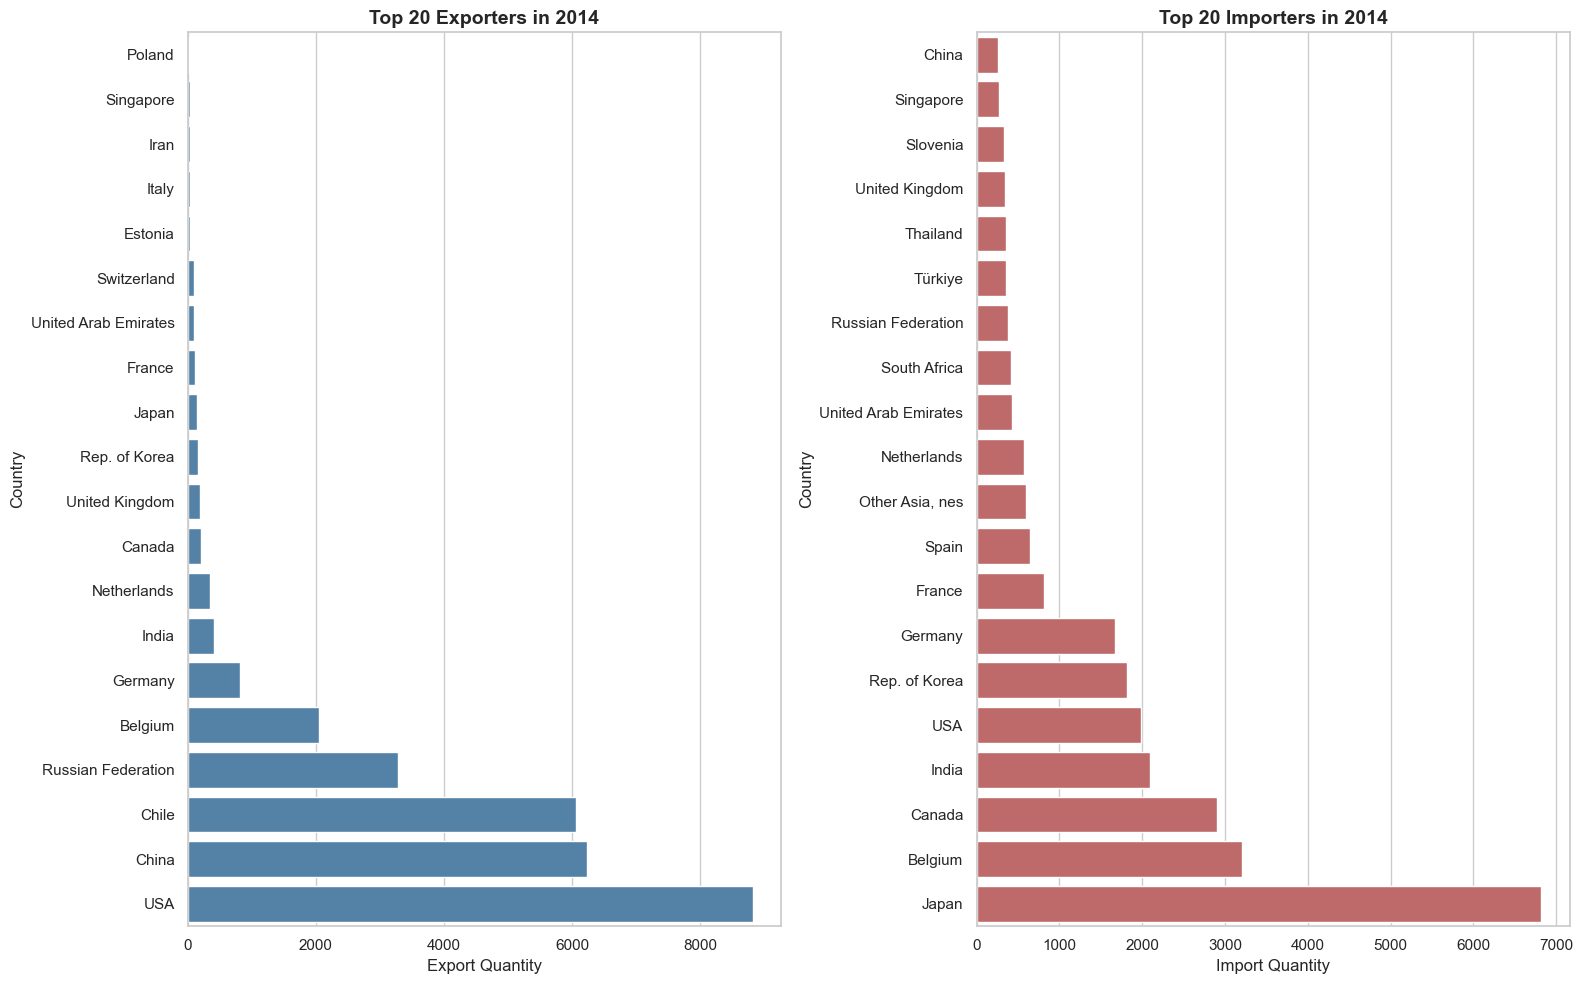

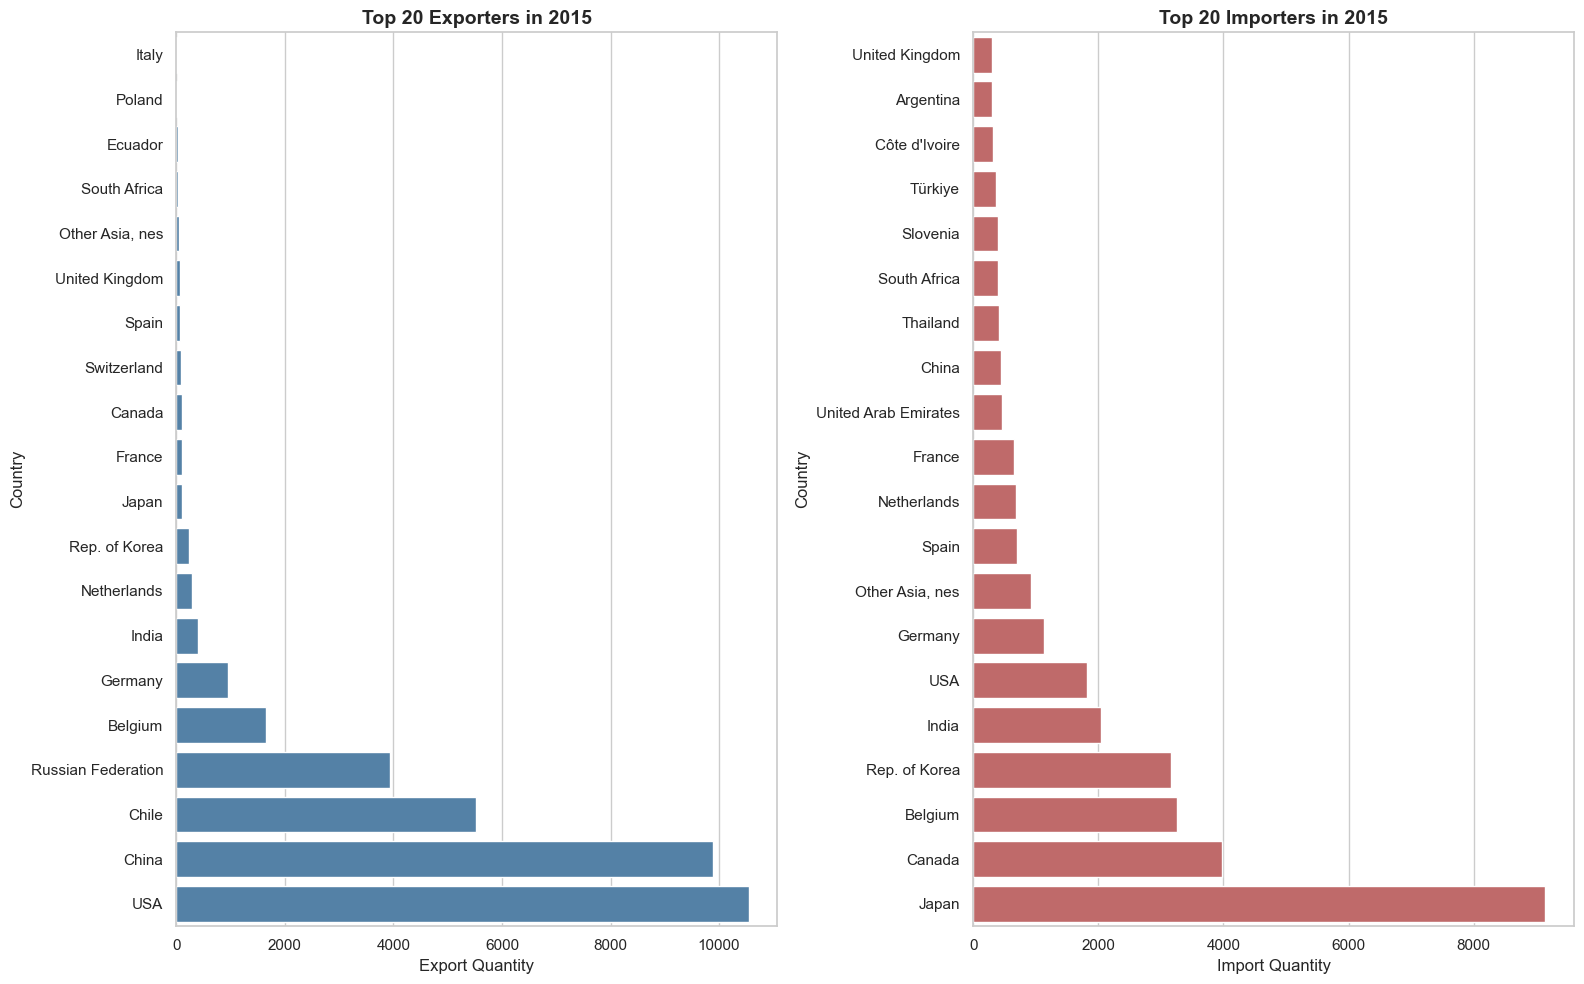

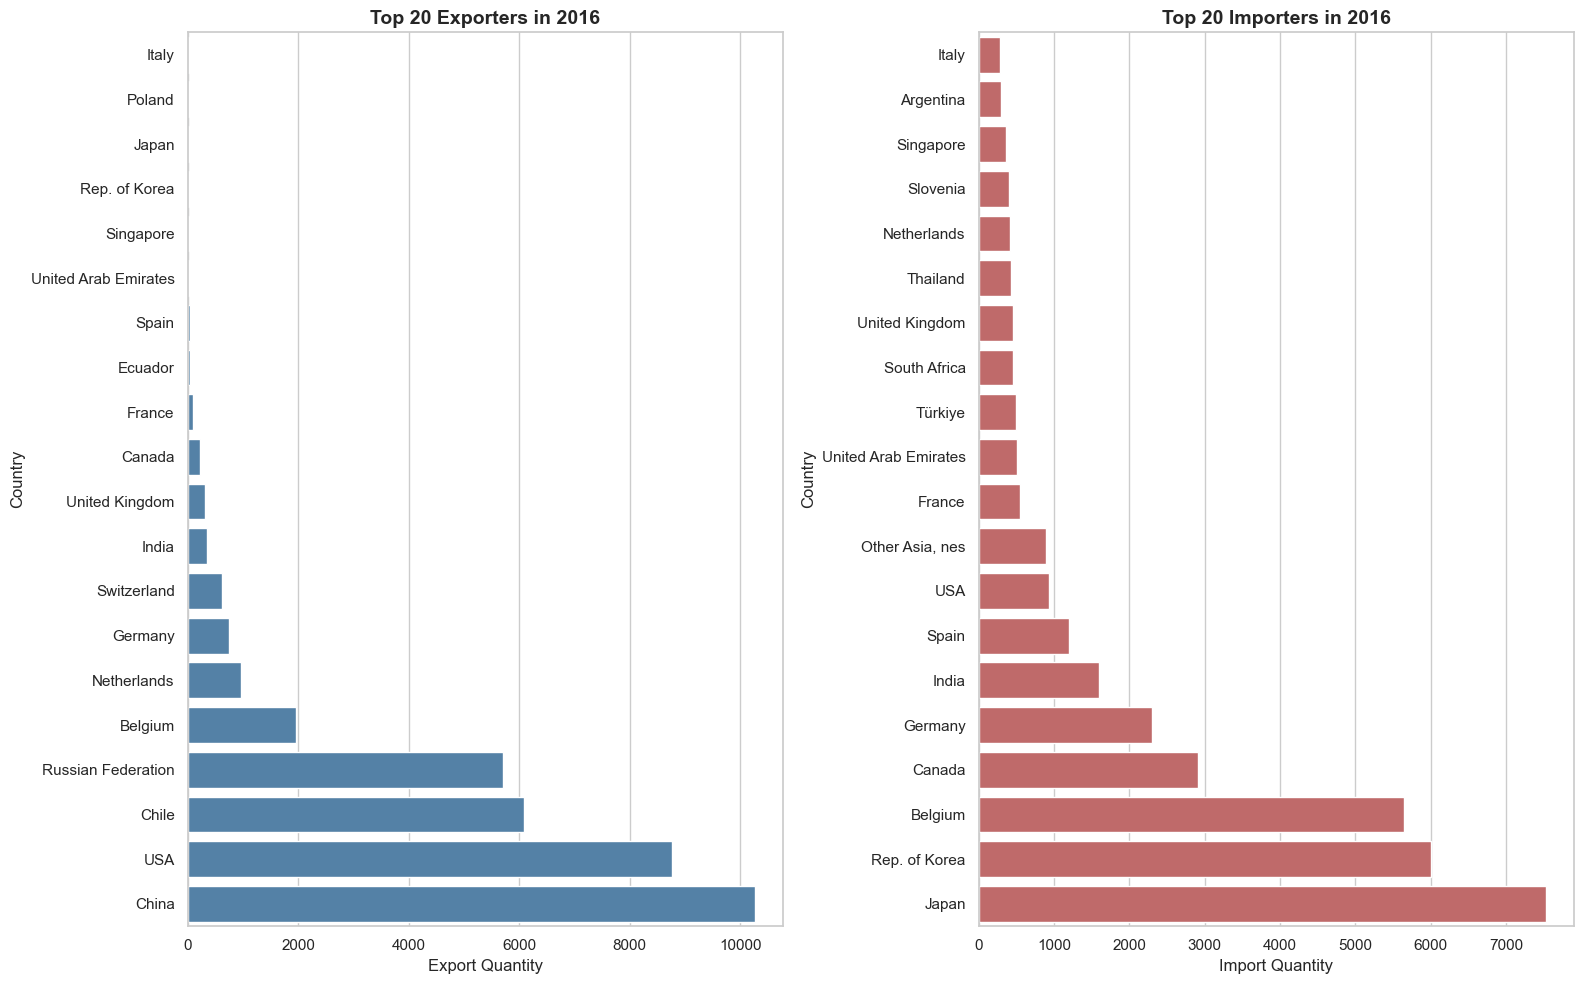

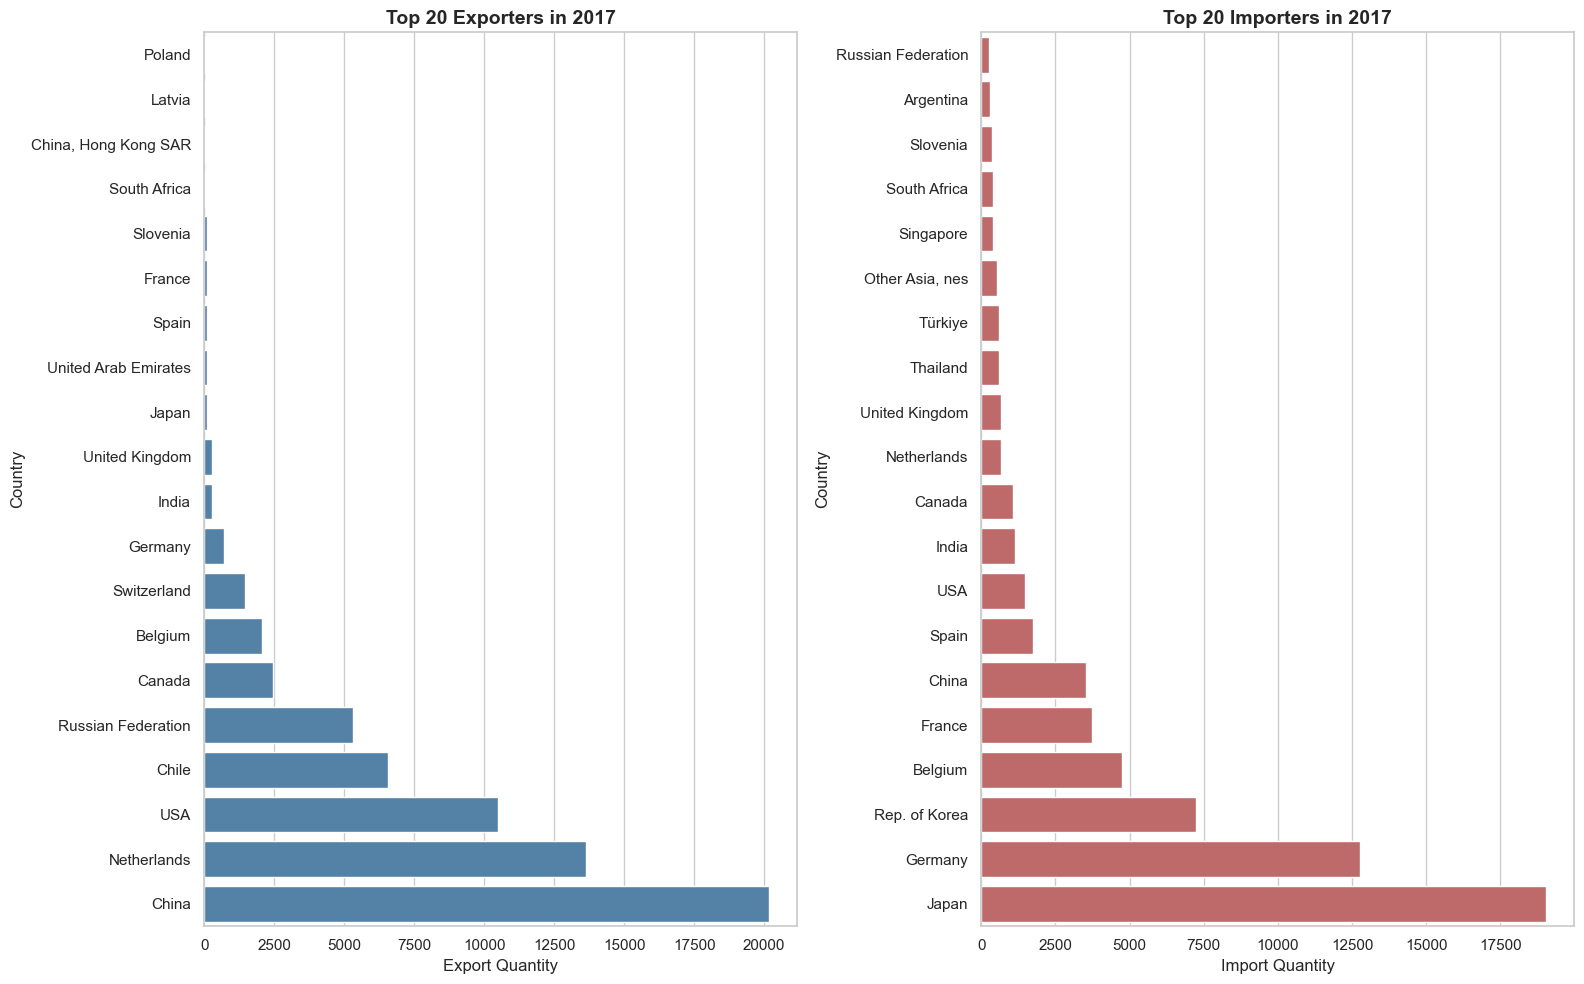

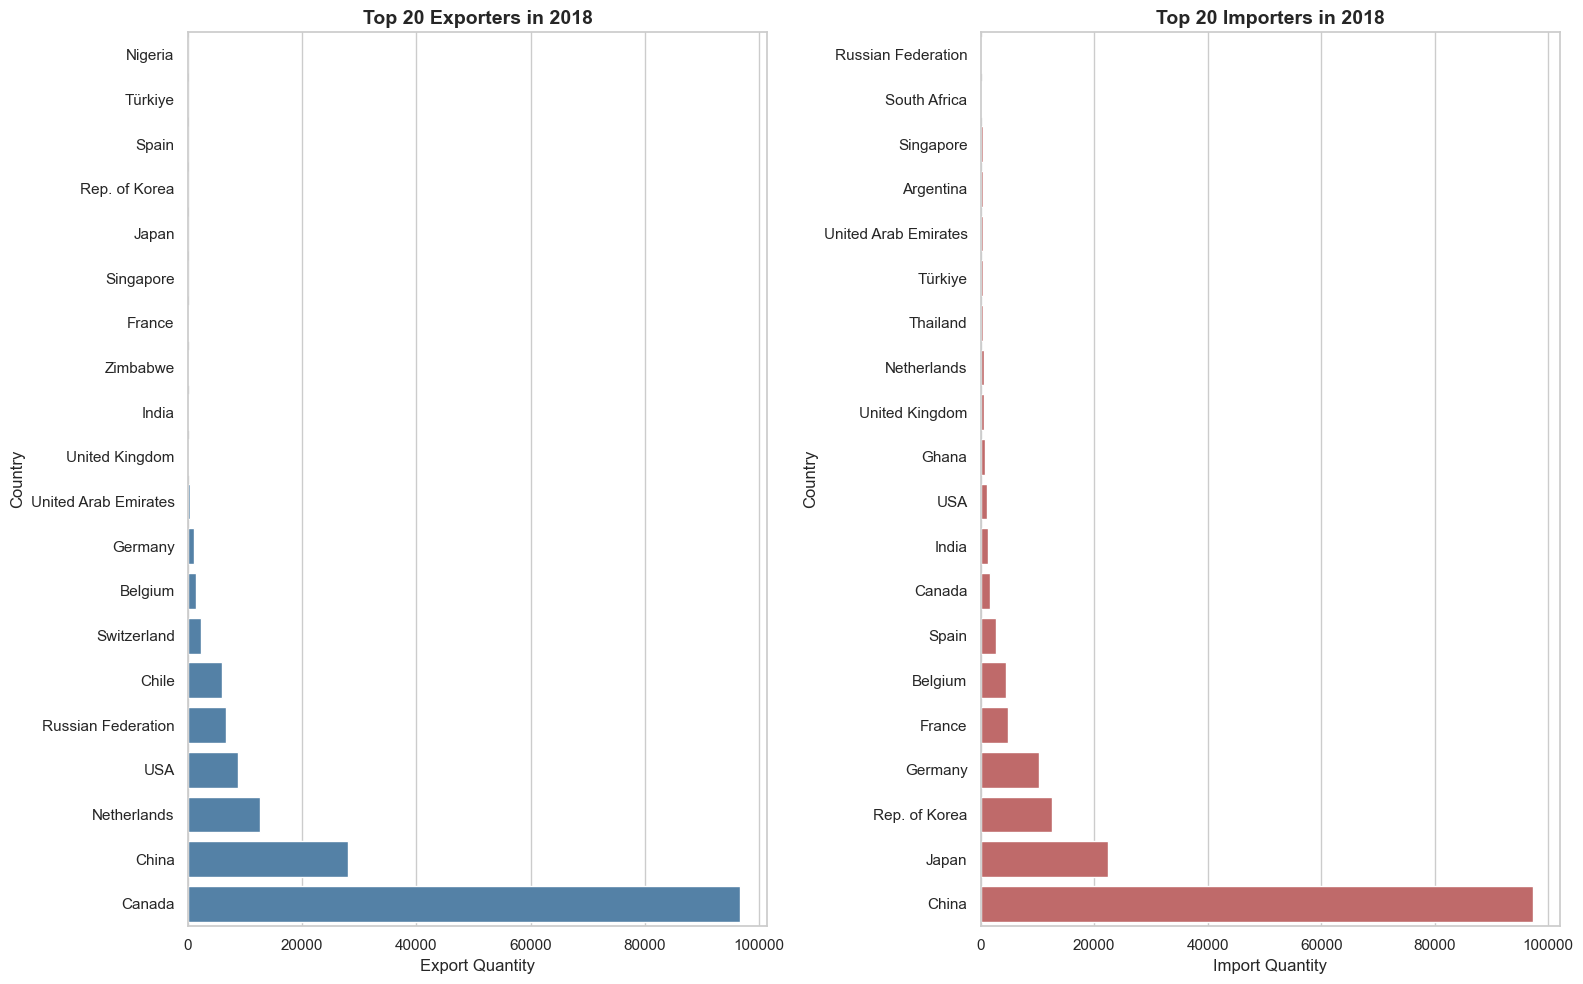

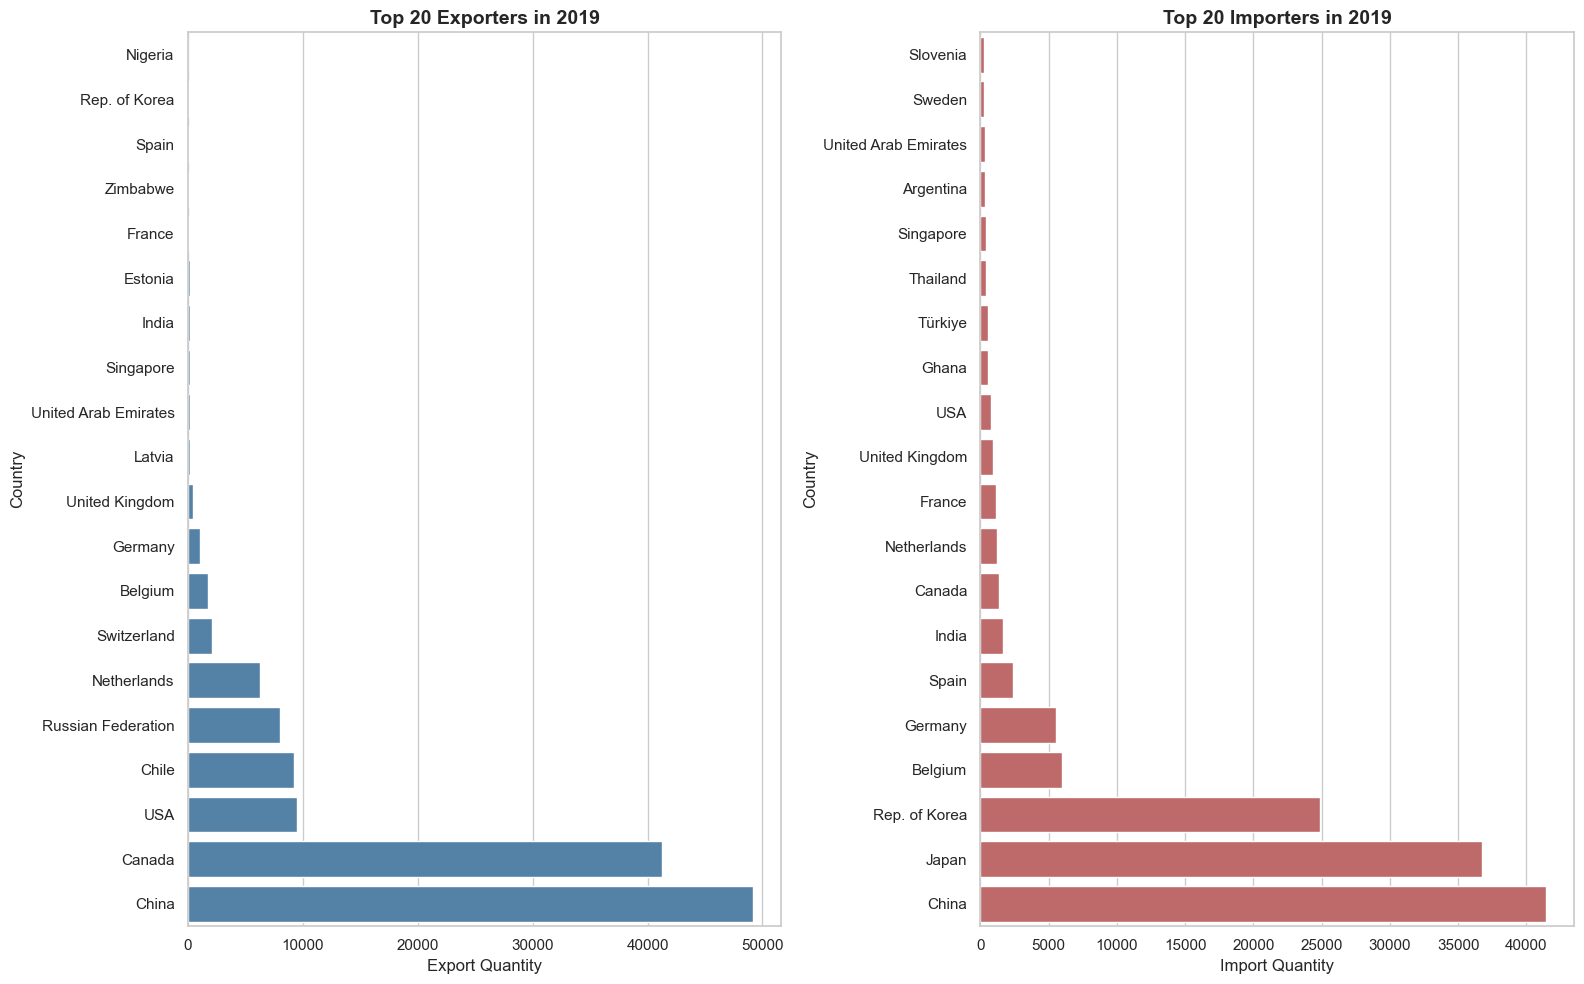

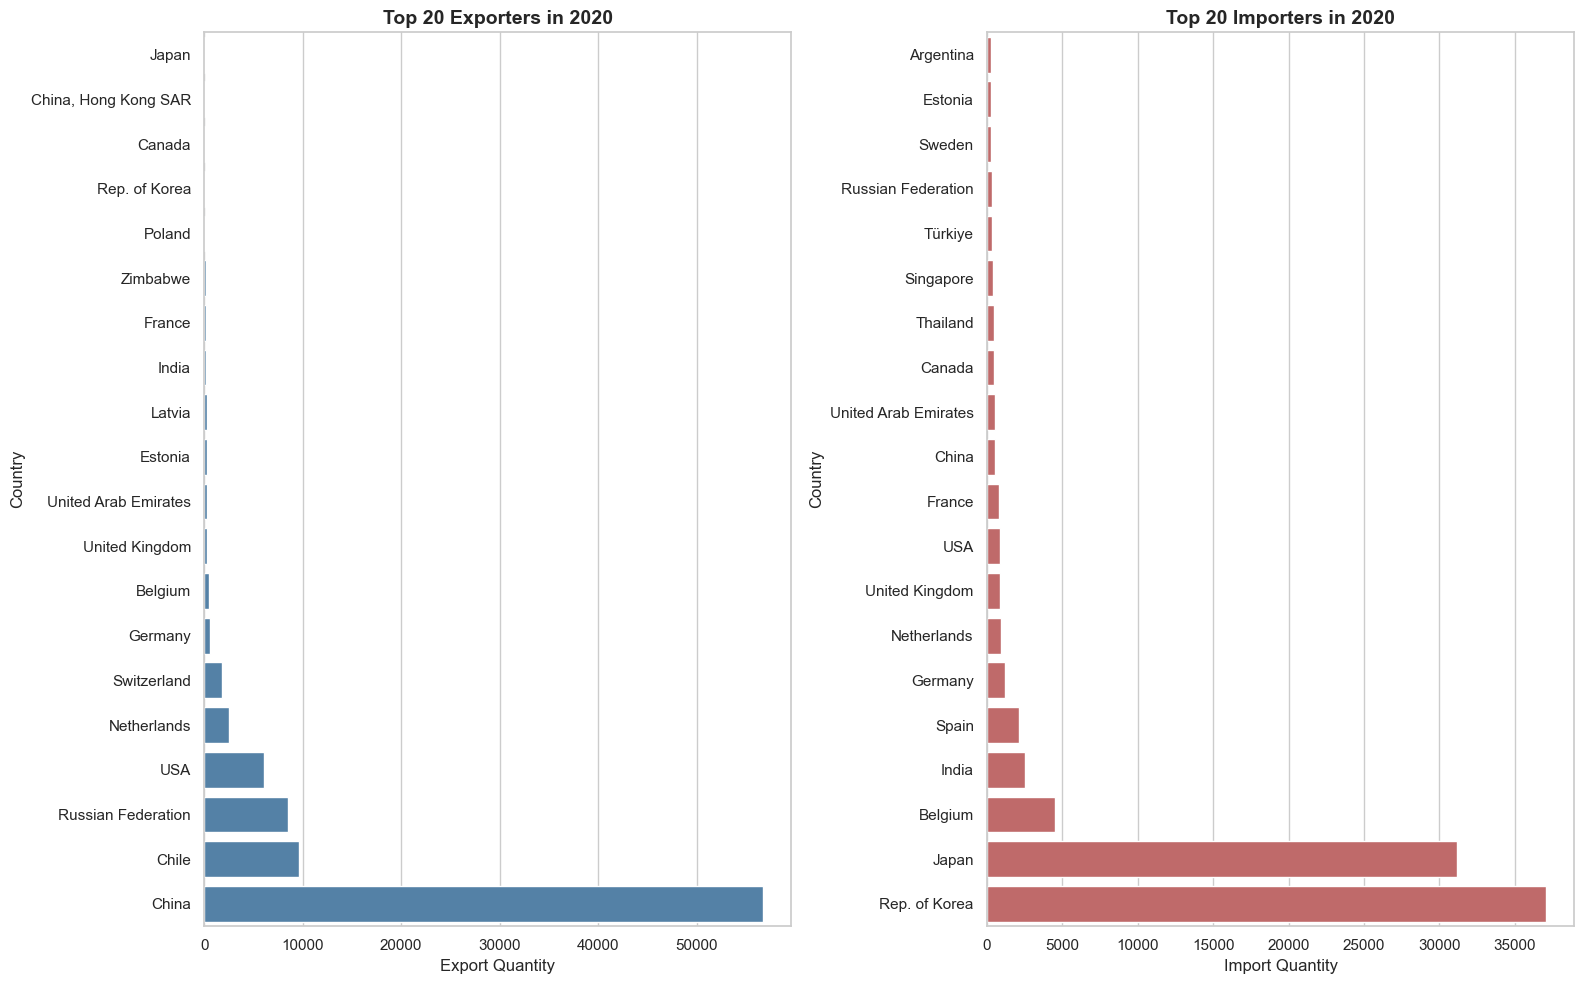

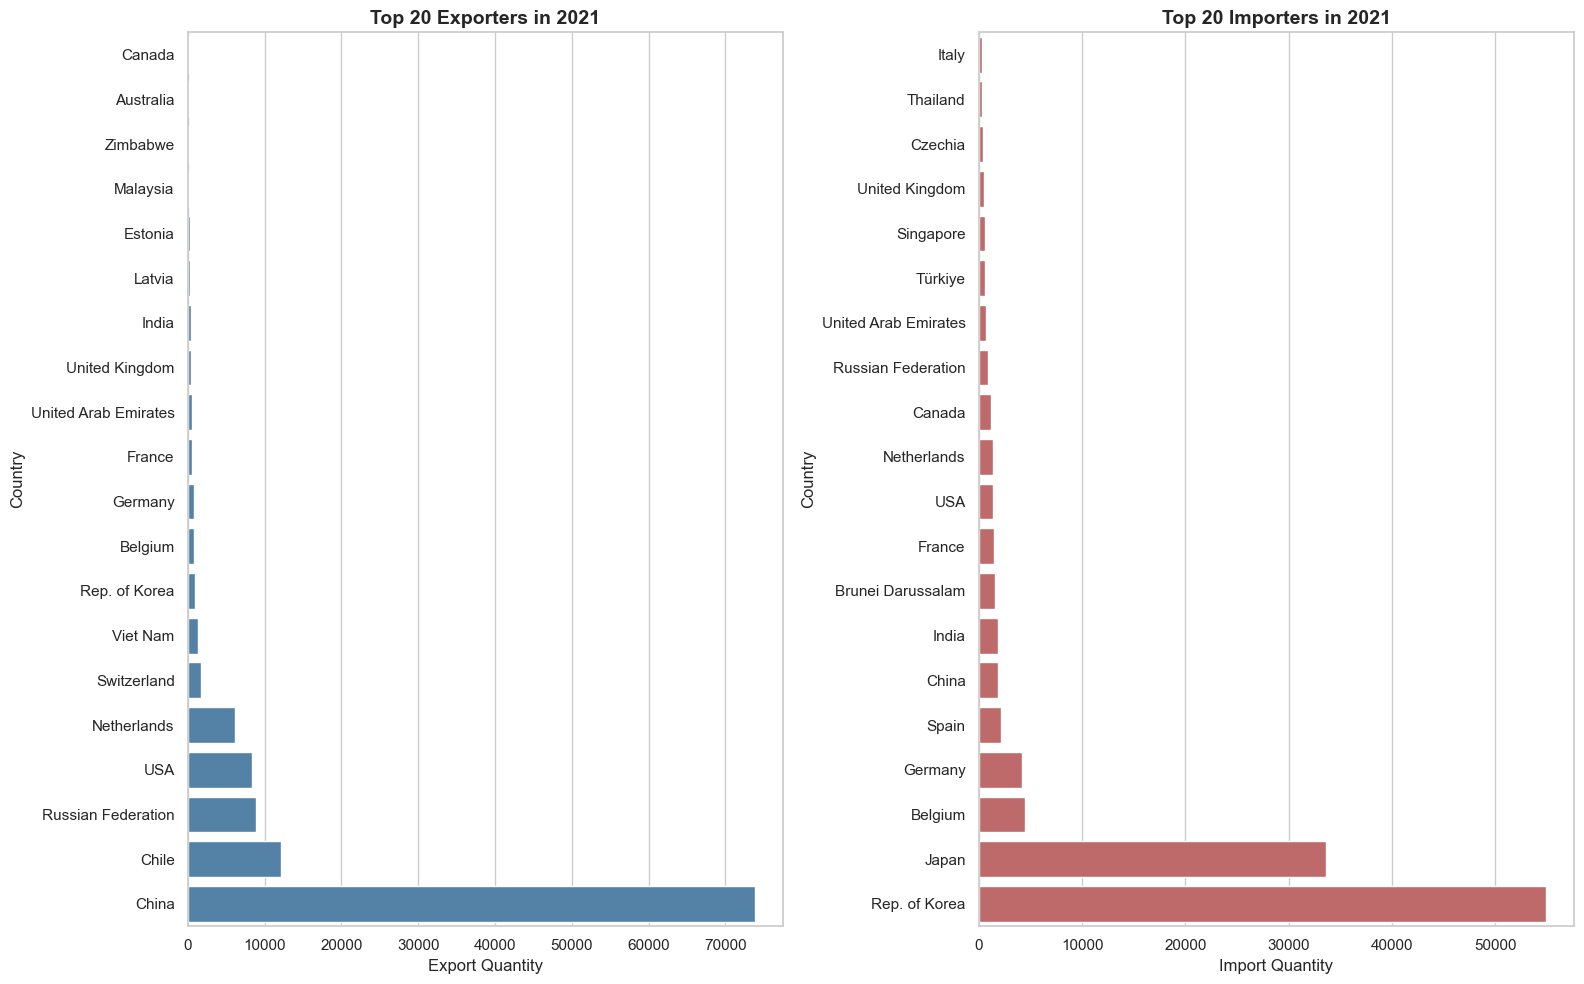

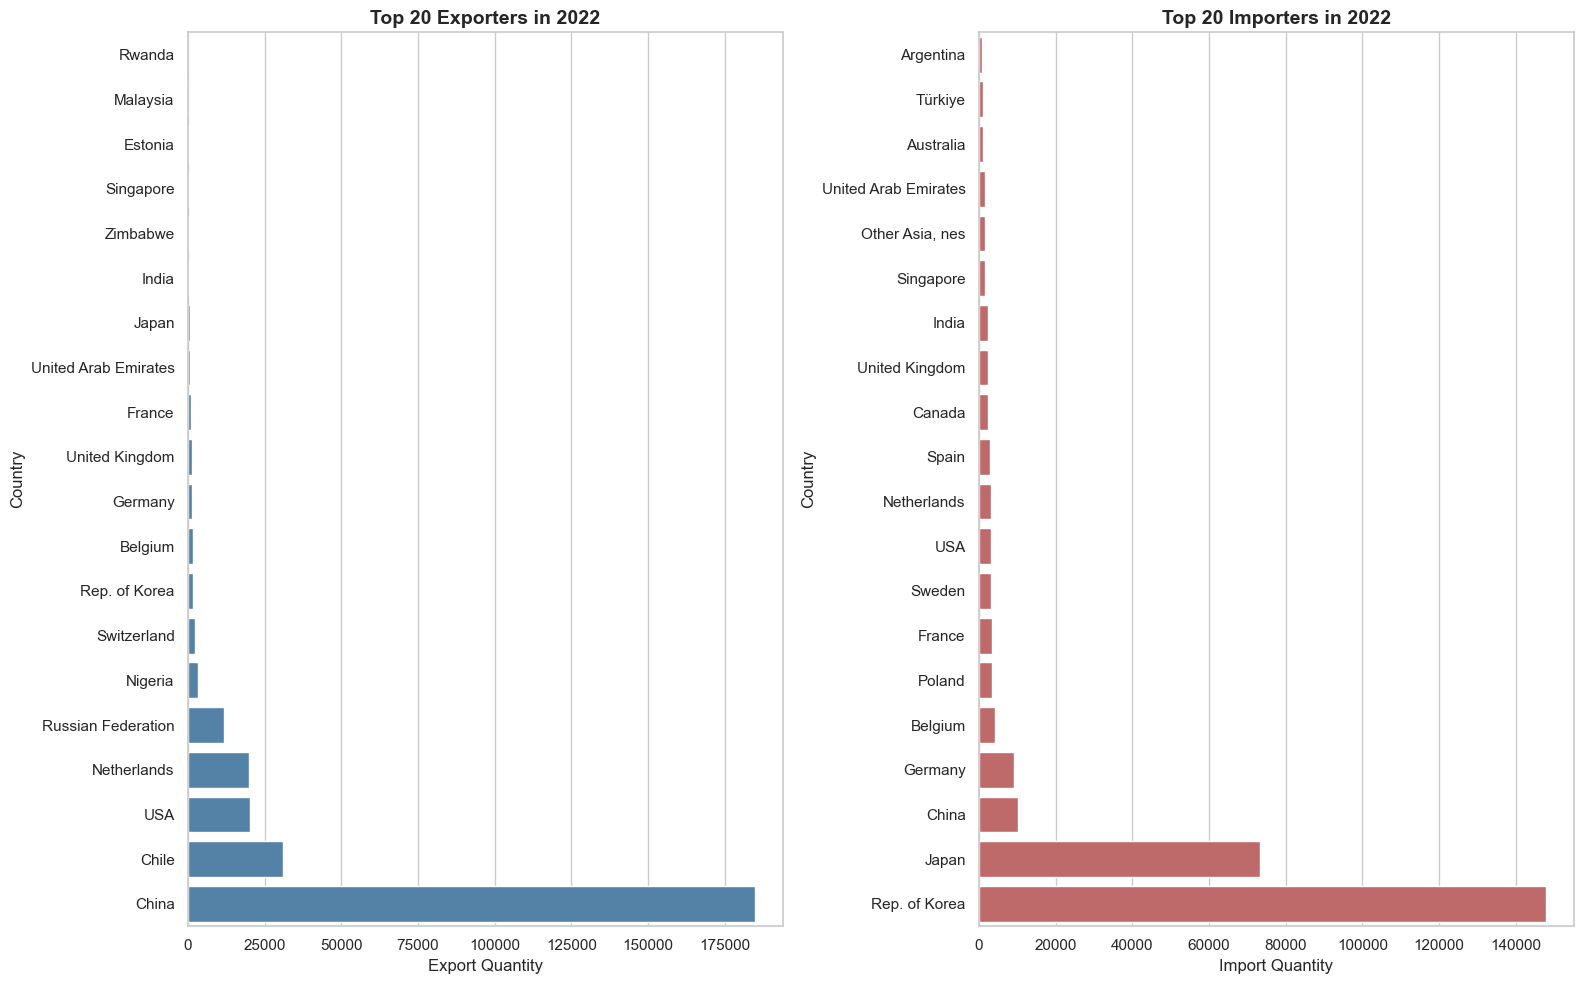

In [4]:
for y in years:
    df_year = df[df['t'] == y]

    # Aggregation by Exporter
    exports = df_year.groupby("export_country")['q'].sum().reset_index()
    exports = exports.sort_values('q', ascending=False).head(top_n)

    # Aggregation by Importer
    imports = df_year.groupby("import_country")['q'].sum().reset_index()
    imports = imports.sort_values('q', ascending=False).head(top_n)

    fig, axs = plt.subplots(1, 2, figsize=(16,10))

    # Visualization of Exporters
    exports = exports.sort_values('q')
    sns.barplot(x='q', y='export_country', data=exports, ax=axs[0], color='steelblue')
    axs[0].set_title(f"Top {top_n} Exporters in {y}", fontsize=14, fontweight='bold')
    axs[0].set_xlabel("Export Quantity")
    axs[0].set_ylabel("Country")

    # Visualization of Importers
    imports = imports.sort_values('q')
    sns.barplot(x='q', y='import_country', data=imports, ax=axs[1], color='indianred')
    axs[1].set_title(f"Top {top_n} Importers in {y}", fontsize=14, fontweight='bold')
    axs[1].set_xlabel("Import Quantity")
    axs[1].set_ylabel("Country")

    plt.tight_layout()
    plt.show()


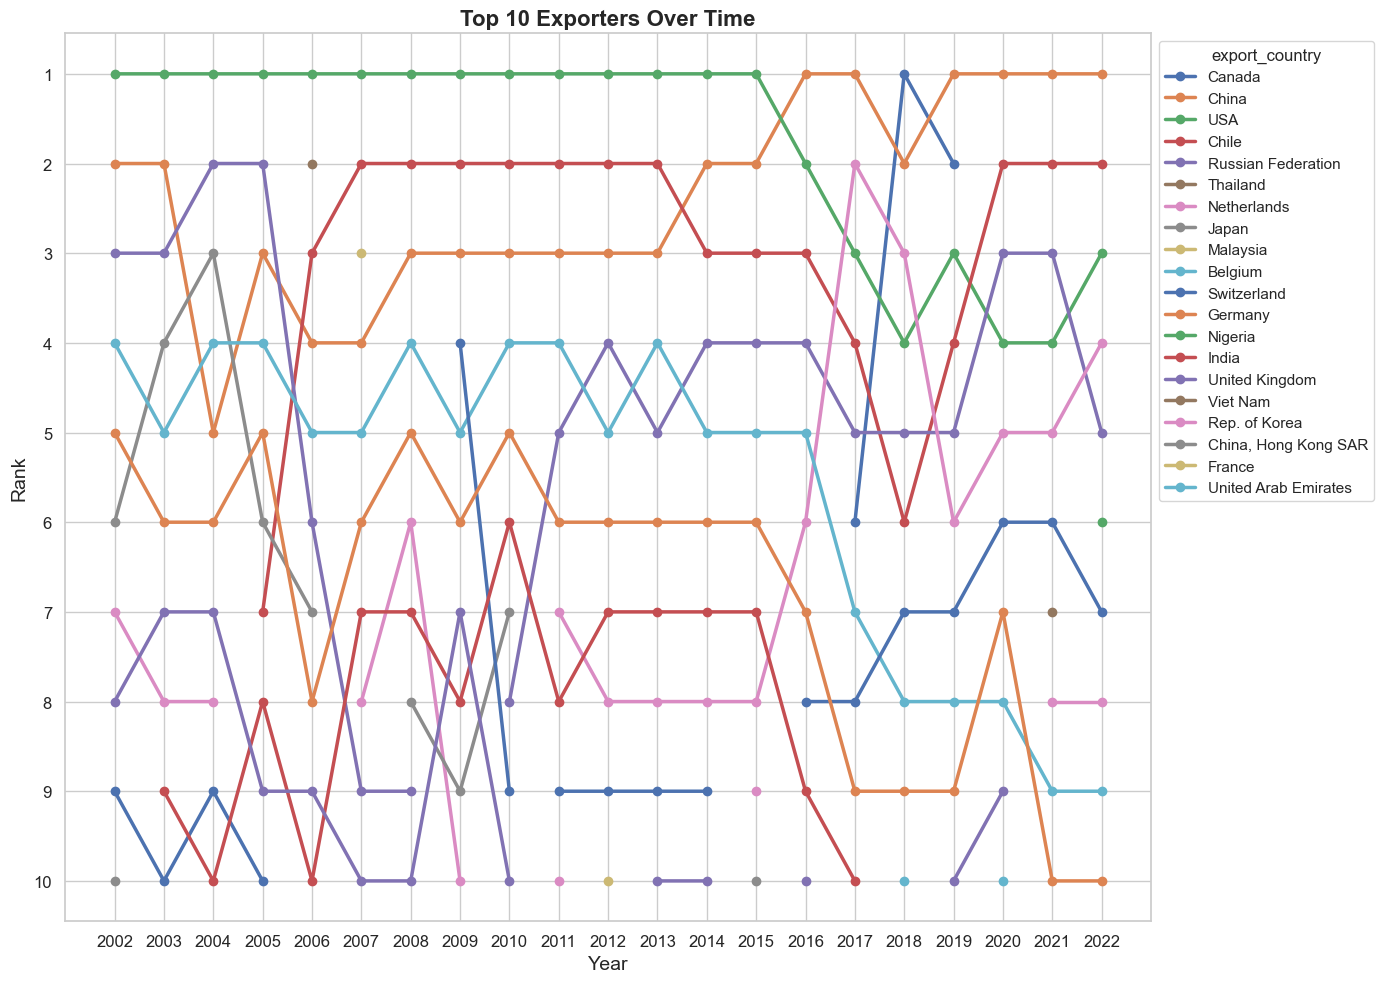

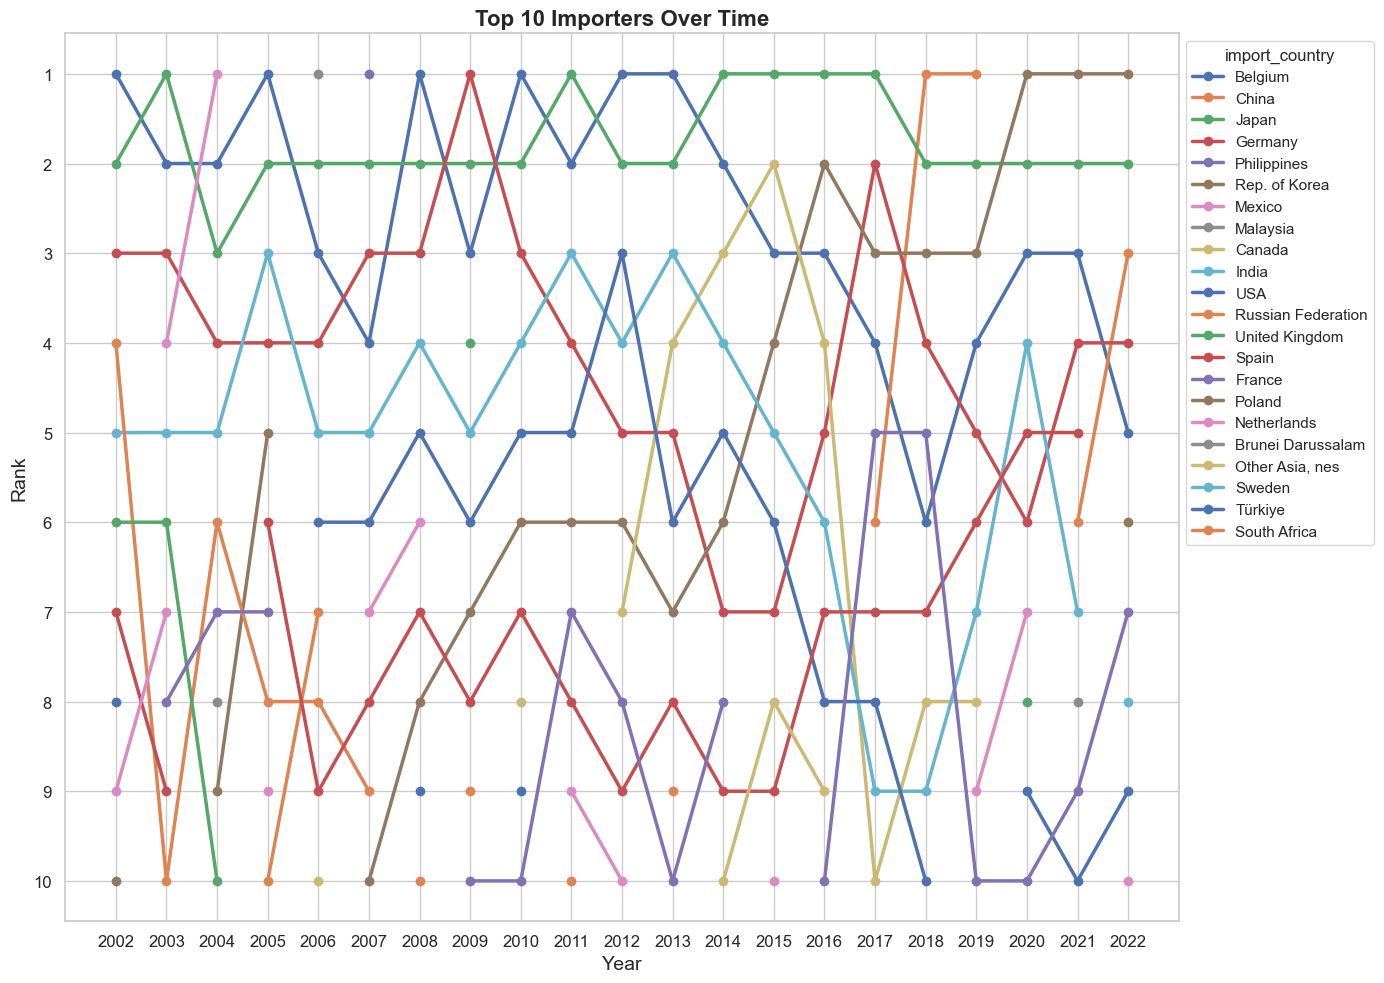

In [5]:


def create_bump_chart(df, category, value_col, time_col, top_n, title):
    df_grouped = (
        df.groupby([time_col, category])[value_col]
        .sum()
        .reset_index()
        .sort_values(by=[time_col, value_col], ascending=[True, False])
    )

    df_grouped['rank'] = (
        df_grouped.groupby(time_col)[value_col]
        .rank(method='first', ascending=False)
        .astype(int)
    )

    df_top = df_grouped[df_grouped['rank'] <= top_n]

    df_pivot = df_top.pivot(index=category, columns=time_col, values='rank')
    df_pivot = df_pivot.loc[df_pivot.min(axis=1).sort_values().index]

    fig, ax = plt.subplots(figsize=(14, 10))

    for idx, row in df_pivot.iterrows():
        ax.plot(
            df_pivot.columns, row, marker='o', label=idx, lw=2.5
        )

    ax.invert_yaxis()
    ax.set_xticks(df_pivot.columns)
    ax.set_yticks(range(1, top_n + 1))
    ax.set_xticklabels(df_pivot.columns, fontsize=12)
    ax.set_yticklabels(range(1, top_n + 1), fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Rank", fontsize=14)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title=category)
    plt.tight_layout()
    plt.show()

polar_df = loader.get_data()
df = polar_df.to_pandas()

top_n = 10
create_bump_chart(
    df,
    category='export_country',
    value_col='q',
    time_col='t',
    top_n=top_n,
    title=f"Top {top_n} Exporters Over Time"
)

create_bump_chart(
    df,
    category='import_country',
    value_col='q',
    time_col='t',
    top_n=top_n,
    title=f"Top {top_n} Importers Over Time"
)


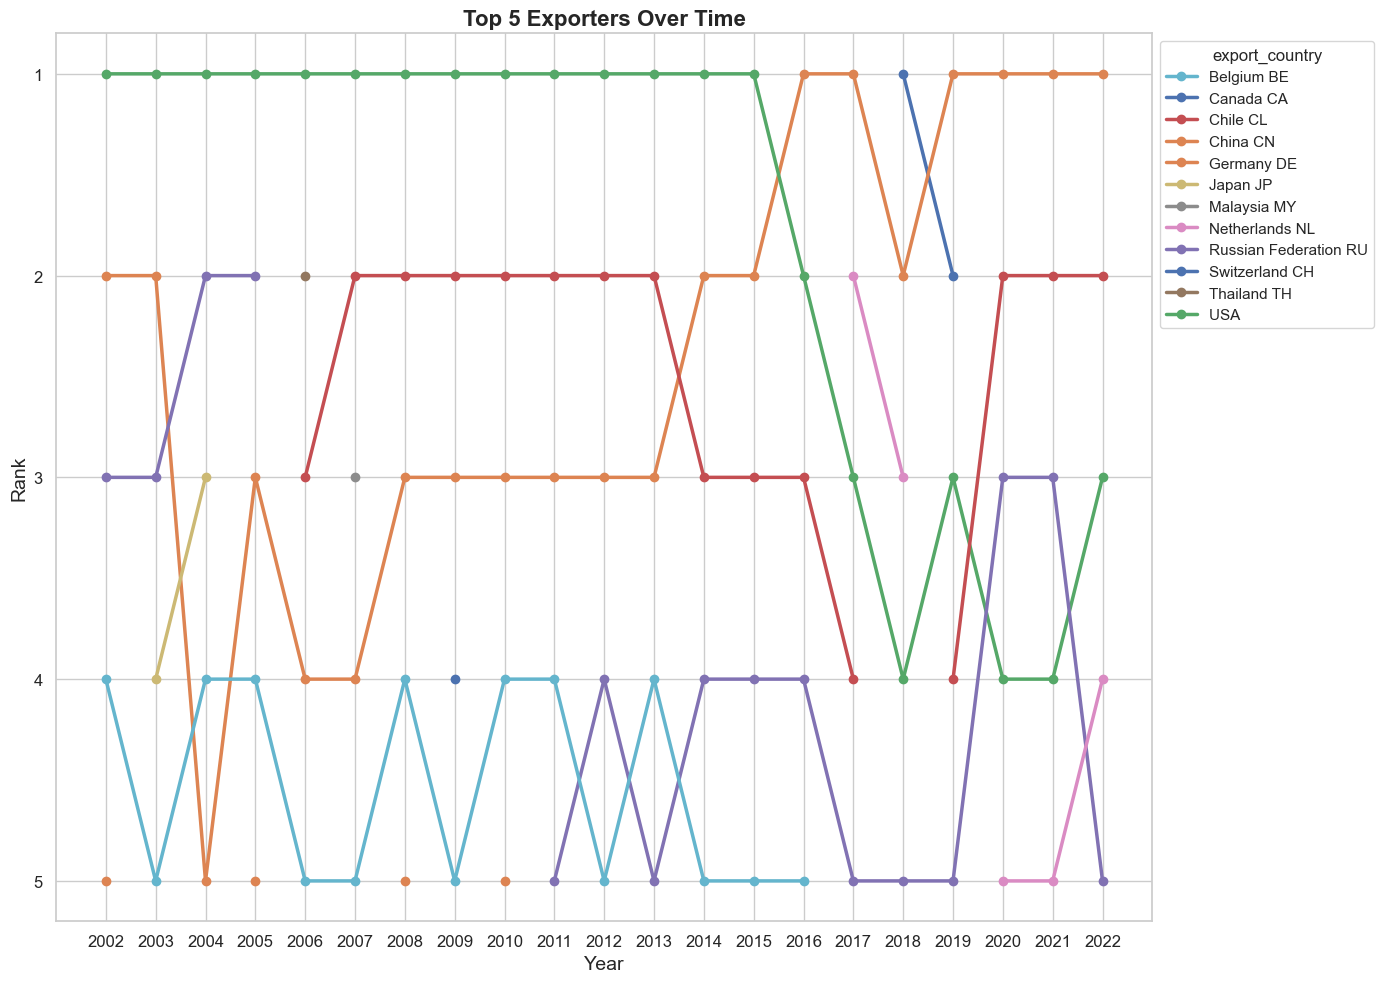

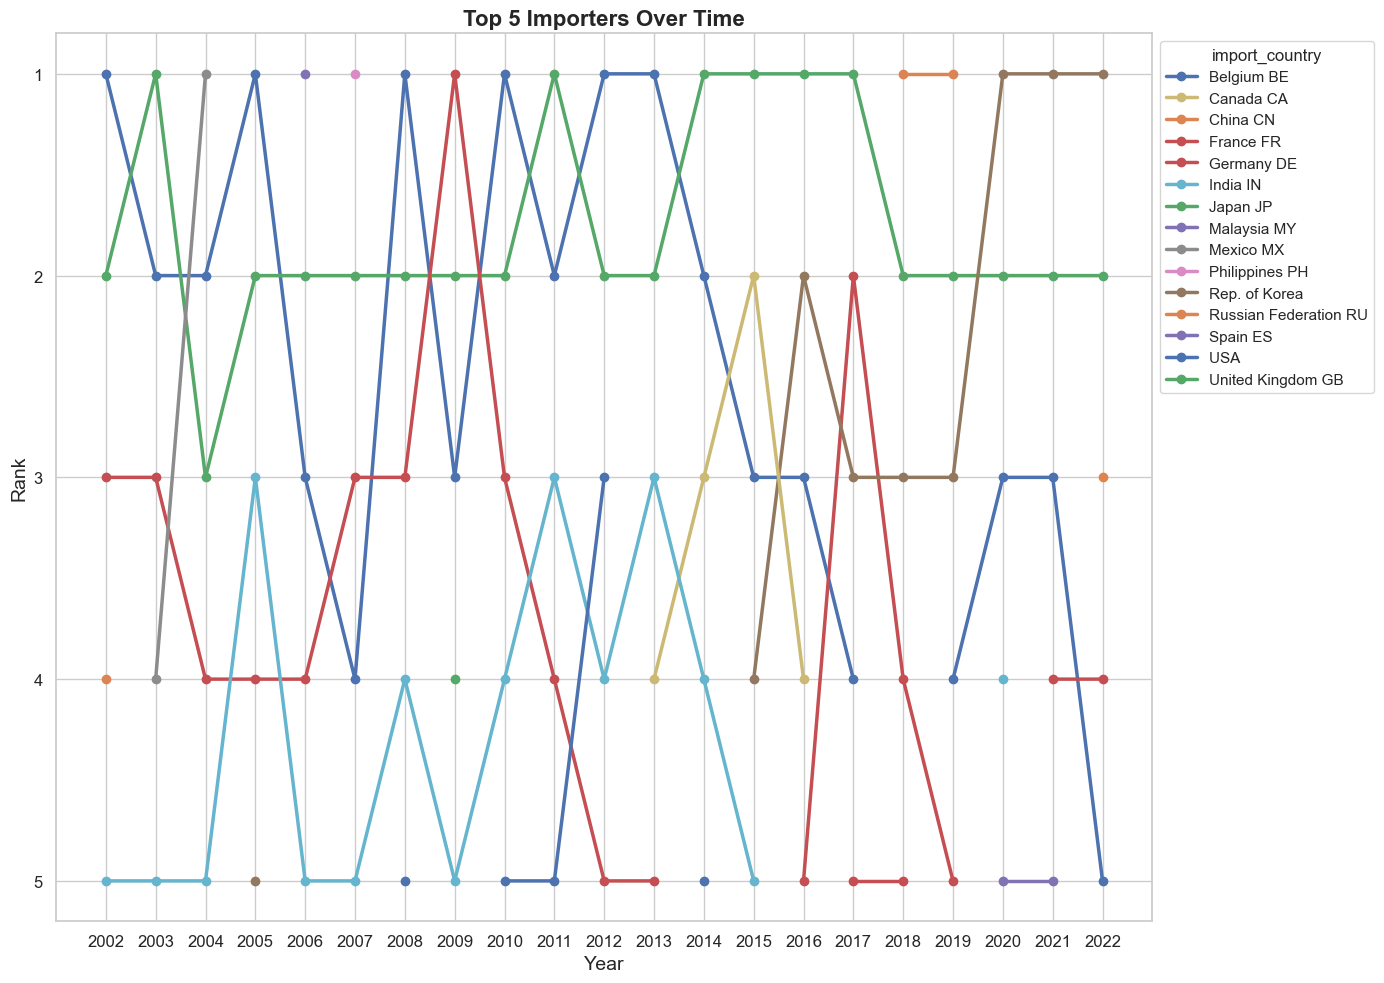

In [9]:


def create_bump_chart(df, category, value_col, time_col, top_n, title):
    df_grouped = (
        df.groupby([time_col, category])[value_col]
        .sum()
        .reset_index()
        .sort_values(by=[time_col, value_col], ascending=[True, False])
    )
    df_grouped['rank'] = (
        df_grouped.groupby(time_col)[value_col]
        .rank(method='first', ascending=False)
        .astype(int)
    )
    df_top = df_grouped[df_grouped['rank'] <= top_n]
    df_pivot = df_top.pivot(index=category, columns=time_col, values='rank')
    df_pivot = df_pivot.loc[df_pivot.min(axis=1).sort_values().index]

    fig, ax = plt.subplots(figsize=(14, 10))

    for idx, row in df_pivot.iterrows():
        country_name = pycountry.countries.get(name=idx)
        country_flag = f"{country_name.alpha_2}" if country_name else ""
        ax.plot(
            df_pivot.columns, row, marker='o', label=f'{idx} {country_flag}', lw=2.5
        )

    ax.invert_yaxis()
    ax.set_xticks(df_pivot.columns)
    ax.set_yticks(range(1, top_n + 1))
    ax.set_xticklabels(df_pivot.columns, fontsize=12)
    ax.set_yticklabels(range(1, top_n + 1), fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Rank", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0])
    sorted_labels, sorted_handles = zip(*sorted_legend)
    ax.legend(sorted_handles, sorted_labels, loc='upper left', bbox_to_anchor=(1, 1), title=category)
    plt.tight_layout()
    plt.show()

polar_df = loader.get_data()
df = polar_df.to_pandas()

top_n = 5
create_bump_chart(
    df,
    category='export_country',
    value_col='q',
    time_col='t',
    top_n=top_n,
    title=f"Top {top_n} Exporters Over Time"
)

create_bump_chart(
    df,
    category='import_country',
    value_col='q',
    time_col='t',
    top_n=top_n,
    title=f"Top {top_n} Importers Over Time"
)
